In [239]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
plt.rcParams['font.family'] = 'Malgun Gothic' # 한글 폰트 설정
plt.rcParams['figure.figsize'] = (10, 6) # 그래프 크기 설정

In [240]:
#전체 컬럼 확인
df = pd.read_csv('volleyball_raw.csv')
df.columns

Index(['경기번호', '팀명', '경기날짜', '결과', 'No.', '이름', '출전세트_1set', '출전세트_2set',
       '출전세트_3set', '출전세트_4set', '출전세트_5set', '득점_득점', '공격종합_시도', '공격종합_성공',
       '공격종합_공격차단', '공격종합_범실', '공격종합_성공률', '공격종합_점유율', '오픈_시도', '오픈_성공',
       '오픈_공격차단', '오픈_범실', '오픈_성공률', '오픈_점유율', '시간차_시도', '시간차_성공', '시간차_공격차단',
       '시간차_범실', '시간차_성공률', '시간차_점유율', '이동_시도', '이동_성공', '이동_공격차단', '이동_범실',
       '이동_성공률', '이동_점유율', '후위_시도', '후위_성공', '후위_공격차단', '후위_범실', '후위_성공률',
       '후위_점유율', '속공_시도', '속공_성공', '속공_공격차단', '속공_범실', '속공_성공률', '속공_점유율',
       '퀵오픈_시도', '퀵오픈_성공', '퀵오픈_공격차단', '퀵오픈_범실', '퀵오픈_성공률', '퀵오픈_점유율', '서브_시도',
       '서브_성공', '서브_범실', '서브_성공률', '서브_점유율', '디그_시도', '디그_성공', '디그_실패',
       '디그_범실', '디그_세트당', '디그_점유율', '세트_시도', '세트_성공', '세트_범실', '세트_세트당',
       '세트_점유율', '리시브_시도', '리시브_정확', '리시브_실패', '리시브_세트당', '리시브_점유율', '블로킹_시도',
       '블로킹_성공', '블로킹_유효블락', '블로킹_실패', '블로킹_범실', '블로킹_세트당', '블로킹_점유율',
       '블로킹_어시스트', '벌칙_벌칙', '범실_범실'],
      dtype='object')

#### No. 열 삭제, 3경기 이상 선수 유지, 스타팅 컬럼추가

In [241]:
# No. 열 삭제
df_sub = df.drop('No.', axis = 1)
df_sub

,경기번호,팀명,경기날짜,결과,이름,출전세트_1set,출전세트_2set,출전세트_3set,출전세트_4set,출전세트_5set,...,블로킹_시도,블로킹_성공,블로킹_유효블락,블로킹_실패,블로킹_범실,블로킹_세트당,블로킹_점유율,블로킹_어시스트,벌칙_벌칙,범실_범실
0,1,IBK기업은행,2017-10-14,0,메디 (L),O,O,O,O,O,...,20,3,5,6,1,0.6,21.28,1,0,7
1,1,IBK기업은행,2017-10-14,0,고예림 (L),O,O,O,O,O,...,10,0,7,3,0,0.0,10.64,0,0,6
2,1,IBK기업은행,2017-10-14,0,김희진 (R),O,O,O,O,O,...,14,4,6,3,0,0.8,14.89,1,0,6
3,1,IBK기업은행,2017-10-14,0,김미연 (L),O,O,O,O,O,...,12,2,2,7,0,0.4,12.77,3,0,1
4,1,IBK기업은행,2017-10-14,0,김수지 (C),O,O,O,O,O,...,28,1,13,9,0,0.2,29.79,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10992,474,KGC인삼공사,2022-02-28,0,김혜원 (S),O,NaN,2,NaN,NaN,...,2,0,1,1,0,0.0,4.44,0,0,0
10993,474,KGC인삼공사,2022-02-28,0,나현수 (C),NaN,17,12,NaN,NaN,...,1,0,0,1,0,0.0,2.22,0,0,2
10994,474,KGC인삼공사,2022-02-28,0,노란 (Li),LI,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0.0,0.00,0,0,0
10995,474,KGC인삼공사,2022-02-28,0,이선우 (L),NaN,2,1,NaN,NaN,...,0,0,0,0,0,0.0,0.00,0,0,0


In [242]:
# 3경기 이상 출전한 선수만 유지 (출전 세트 결측치가 3개 이상인 선수 제거)
subset = ['출전세트_1set', '출전세트_2set', '출전세트_3set', '출전세트_4set', '출전세트_5set']

# thresh = 3 : 정상 값(Not NaN)이 3개 이상만 유지
df_sub = df_sub.dropna(subset = subset, thresh = 3)
df_sub

,경기번호,팀명,경기날짜,결과,이름,출전세트_1set,출전세트_2set,출전세트_3set,출전세트_4set,출전세트_5set,...,블로킹_시도,블로킹_성공,블로킹_유효블락,블로킹_실패,블로킹_범실,블로킹_세트당,블로킹_점유율,블로킹_어시스트,벌칙_벌칙,범실_범실
0,1,IBK기업은행,2017-10-14,0,메디 (L),O,O,O,O,O,...,20,3,5,6,1,0.60,21.28,1,0,7
1,1,IBK기업은행,2017-10-14,0,고예림 (L),O,O,O,O,O,...,10,0,7,3,0,0.00,10.64,0,0,6
2,1,IBK기업은행,2017-10-14,0,김희진 (R),O,O,O,O,O,...,14,4,6,3,0,0.80,14.89,1,0,6
3,1,IBK기업은행,2017-10-14,0,김미연 (L),O,O,O,O,O,...,12,2,2,7,0,0.40,12.77,3,0,1
4,1,IBK기업은행,2017-10-14,0,김수지 (C),O,O,O,O,O,...,28,1,13,9,0,0.20,29.79,2,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10988,474,KGC인삼공사,2022-02-28,0,한송이 (C),O,O,O,NaN,NaN,...,14,2,5,5,0,0.67,31.11,2,0,0
10989,474,KGC인삼공사,2022-02-28,0,정호영 (C),O,O,O,NaN,NaN,...,2,0,0,2,0,0.00,4.44,3,0,0
10990,474,KGC인삼공사,2022-02-28,0,고의정 (L),12,11,11,NaN,NaN,...,0,0,0,0,0,0.00,0.00,0,0,1
10991,474,KGC인삼공사,2022-02-28,0,하효림 (S),14,O,O,NaN,NaN,...,4,0,2,1,0,0.00,8.89,2,0,0


In [243]:
# 스타팅멤버 표시 (3세트 이상 스타팅멤버라면 1 아니면 0)
df_sub['스타팅멤버'] = 0
df_sub.loc[(df_sub.iloc[:, 5:10] == 'O').sum(axis = 1) >= 3, '스타팅멤버'] = 1

df_sub

C:\Users\ice_9\AppData\Local\Temp\ipykernel_16092\2217063058.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['스타팅멤버'] = 0


,경기번호,팀명,경기날짜,결과,이름,출전세트_1set,출전세트_2set,출전세트_3set,출전세트_4set,출전세트_5set,...,블로킹_성공,블로킹_유효블락,블로킹_실패,블로킹_범실,블로킹_세트당,블로킹_점유율,블로킹_어시스트,벌칙_벌칙,범실_범실,스타팅멤버
0,1,IBK기업은행,2017-10-14,0,메디 (L),O,O,O,O,O,...,3,5,6,1,0.60,21.28,1,0,7,1
1,1,IBK기업은행,2017-10-14,0,고예림 (L),O,O,O,O,O,...,0,7,3,0,0.00,10.64,0,0,6,1
2,1,IBK기업은행,2017-10-14,0,김희진 (R),O,O,O,O,O,...,4,6,3,0,0.80,14.89,1,0,6,1
3,1,IBK기업은행,2017-10-14,0,김미연 (L),O,O,O,O,O,...,2,2,7,0,0.40,12.77,3,0,1,1
4,1,IBK기업은행,2017-10-14,0,김수지 (C),O,O,O,O,O,...,1,13,9,0,0.20,29.79,2,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10988,474,KGC인삼공사,2022-02-28,0,한송이 (C),O,O,O,NaN,NaN,...,2,5,5,0,0.67,31.11,2,0,0,1
10989,474,KGC인삼공사,2022-02-28,0,정호영 (C),O,O,O,NaN,NaN,...,0,0,2,0,0.00,4.44,3,0,0,1
10990,474,KGC인삼공사,2022-02-28,0,고의정 (L),12,11,11,NaN,NaN,...,0,0,0,0,0.00,0.00,0,0,1,0
10991,474,KGC인삼공사,2022-02-28,0,하효림 (S),14,O,O,NaN,NaN,...,0,2,1,0,0.00,8.89,2,0,0,0


In [244]:
df_sub['스타팅멤버'].value_counts()

1    5315
0    2801
Name: 스타팅멤버, dtype: int64

### 각 경기당 세트수 컬럼 추가

In [245]:
# 경기번호에 대한 행의 갯수와 NaN값 비교
# 4세트 NaN값과 행의 갯수가 같으면 3세트만 진행한 것, 5세트 NaN값과 행의 갯수가 같으면 4세트만 진행한 것, 나머지는 5세트 모두 진행한 것
# 경기번호는 1~474까지 있으므로 range범위 지정

for i in range(1, 475):
    temp = df_sub['경기번호']== i
    if len(df_sub.loc[temp]) == df_sub.loc[temp]['출전세트_4set'].isna().sum():
        df_sub.loc[temp, '세트수'] = 3
    elif len(df_sub.loc[temp]) == df_sub.loc[temp]['출전세트_5set'].isna().sum():
        df_sub.loc[temp, '세트수'] = 4
    else:
        df_sub.loc[temp, '세트수'] = 5

display(df_sub['세트수'].value_counts()) # 3, 4, 5세트의 각각의 행 갯수 출력
df_sub

C:\Users\ice_9\AppData\Local\Temp\ipykernel_16092\4039974893.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.loc[temp, '세트수'] = 5


3.0    3012
4.0    2740
5.0    2364
Name: 세트수, dtype: int64

,경기번호,팀명,경기날짜,결과,이름,출전세트_1set,출전세트_2set,출전세트_3set,출전세트_4set,출전세트_5set,...,블로킹_유효블락,블로킹_실패,블로킹_범실,블로킹_세트당,블로킹_점유율,블로킹_어시스트,벌칙_벌칙,범실_범실,스타팅멤버,세트수
0,1,IBK기업은행,2017-10-14,0,메디 (L),O,O,O,O,O,...,5,6,1,0.60,21.28,1,0,7,1,5.0
1,1,IBK기업은행,2017-10-14,0,고예림 (L),O,O,O,O,O,...,7,3,0,0.00,10.64,0,0,6,1,5.0
2,1,IBK기업은행,2017-10-14,0,김희진 (R),O,O,O,O,O,...,6,3,0,0.80,14.89,1,0,6,1,5.0
3,1,IBK기업은행,2017-10-14,0,김미연 (L),O,O,O,O,O,...,2,7,0,0.40,12.77,3,0,1,1,5.0
4,1,IBK기업은행,2017-10-14,0,김수지 (C),O,O,O,O,O,...,13,9,0,0.20,29.79,2,0,3,1,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10988,474,KGC인삼공사,2022-02-28,0,한송이 (C),O,O,O,NaN,NaN,...,5,5,0,0.67,31.11,2,0,0,1,3.0
10989,474,KGC인삼공사,2022-02-28,0,정호영 (C),O,O,O,NaN,NaN,...,0,2,0,0.00,4.44,3,0,0,1,3.0
10990,474,KGC인삼공사,2022-02-28,0,고의정 (L),12,11,11,NaN,NaN,...,0,0,0,0.00,0.00,0,0,1,0,3.0
10991,474,KGC인삼공사,2022-02-28,0,하효림 (S),14,O,O,NaN,NaN,...,2,1,0,0.00,8.89,2,0,0,0,3.0


In [246]:
# 세트수 타입 float64 => int64 변경
df_sub['세트수'] = df_sub['세트수'].astype('int64')
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8116 entries, 0 to 10996
Data columns (total 86 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   경기번호       8116 non-null   int64  
 1   팀명         8116 non-null   object 
 2   경기날짜       8116 non-null   object 
 3   결과         8116 non-null   int64  
 4   이름         8116 non-null   object 
 5   출전세트_1set  7791 non-null   object 
 6   출전세트_2set  7911 non-null   object 
 7   출전세트_3set  7896 non-null   object 
 8   출전세트_4set  4756 non-null   object 
 9   출전세트_5set  2124 non-null   object 
 10  득점_득점      8116 non-null   int64  
 11  공격종합_시도    8116 non-null   int64  
 12  공격종합_성공    8116 non-null   int64  
 13  공격종합_공격차단  8116 non-null   int64  
 14  공격종합_범실    8116 non-null   int64  
 15  공격종합_성공률   8116 non-null   float64
 16  공격종합_점유율   8116 non-null   float64
 17  오픈_시도      8116 non-null   int64  
 18  오픈_성공      8116 non-null   int64  
 19  오픈_공격차단    8116 non-null   int64  
 20  오픈_범실  

C:\Users\ice_9\AppData\Local\Temp\ipykernel_16092\1882691837.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['세트수'] = df_sub['세트수'].astype('int64')


In [247]:
# 출전 세트 열 삭제
subset = ['출전세트_1set', '출전세트_2set', '출전세트_3set', '출전세트_4set', '출전세트_5set']

df_sub = df_sub.drop(subset, axis = 1)
df_sub

,경기번호,팀명,경기날짜,결과,이름,득점_득점,공격종합_시도,공격종합_성공,공격종합_공격차단,공격종합_범실,...,블로킹_유효블락,블로킹_실패,블로킹_범실,블로킹_세트당,블로킹_점유율,블로킹_어시스트,벌칙_벌칙,범실_범실,스타팅멤버,세트수
0,1,IBK기업은행,2017-10-14,0,메디 (L),24,67,20,4,2,...,5,6,1,0.60,21.28,1,0,7,1,5
1,1,IBK기업은행,2017-10-14,0,고예림 (L),15,40,12,6,4,...,7,3,0,0.00,10.64,0,0,6,1,5
2,1,IBK기업은행,2017-10-14,0,김희진 (R),15,36,10,2,2,...,6,3,0,0.80,14.89,1,0,6,1,5
3,1,IBK기업은행,2017-10-14,0,김미연 (L),7,16,5,1,0,...,2,7,0,0.40,12.77,3,0,1,1,5
4,1,IBK기업은행,2017-10-14,0,김수지 (C),6,16,4,1,2,...,13,9,0,0.20,29.79,2,0,3,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10988,474,KGC인삼공사,2022-02-28,0,한송이 (C),4,7,2,2,0,...,5,5,0,0.67,31.11,2,0,0,1,3
10989,474,KGC인삼공사,2022-02-28,0,정호영 (C),3,5,3,1,0,...,0,2,0,0.00,4.44,3,0,0,1,3
10990,474,KGC인삼공사,2022-02-28,0,고의정 (L),1,3,0,0,0,...,0,0,0,0.00,0.00,0,0,1,0,3
10991,474,KGC인삼공사,2022-02-28,0,하효림 (S),1,0,0,0,0,...,2,1,0,0.00,8.89,2,0,0,0,3


In [248]:
# 이름과 포지션 분리하기
# "이름" 열 : 이름 정보
# "포지션" 열 : 포지션 정보

df_sub['포지션'] = df_sub['이름'].str.split().str[1].str.strip('()')
df_sub['이름'] = df_sub['이름'].str.split().str[0]

df_sub

,경기번호,팀명,경기날짜,결과,이름,득점_득점,공격종합_시도,공격종합_성공,공격종합_공격차단,공격종합_범실,...,블로킹_실패,블로킹_범실,블로킹_세트당,블로킹_점유율,블로킹_어시스트,벌칙_벌칙,범실_범실,스타팅멤버,세트수,포지션
0,1,IBK기업은행,2017-10-14,0,메디,24,67,20,4,2,...,6,1,0.60,21.28,1,0,7,1,5,L
1,1,IBK기업은행,2017-10-14,0,고예림,15,40,12,6,4,...,3,0,0.00,10.64,0,0,6,1,5,L
2,1,IBK기업은행,2017-10-14,0,김희진,15,36,10,2,2,...,3,0,0.80,14.89,1,0,6,1,5,R
3,1,IBK기업은행,2017-10-14,0,김미연,7,16,5,1,0,...,7,0,0.40,12.77,3,0,1,1,5,L
4,1,IBK기업은행,2017-10-14,0,김수지,6,16,4,1,2,...,9,0,0.20,29.79,2,0,3,1,5,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10988,474,KGC인삼공사,2022-02-28,0,한송이,4,7,2,2,0,...,5,0,0.67,31.11,2,0,0,1,3,C
10989,474,KGC인삼공사,2022-02-28,0,정호영,3,5,3,1,0,...,2,0,0.00,4.44,3,0,0,1,3,C
10990,474,KGC인삼공사,2022-02-28,0,고의정,1,3,0,0,0,...,0,0,0.00,0.00,0,0,1,0,3,L
10991,474,KGC인삼공사,2022-02-28,0,하효림,1,0,0,0,0,...,1,0,0.00,8.89,2,0,0,0,3,S


### 세트 수에 따른 팀별 승률

In [249]:
winning_rate = df_sub.groupby(['세트수','팀명'])[['결과']].mean()
winning_rate.columns=['승률']
winning_rate = winning_rate.reset_index()
winning_rate

,세트수,팀명,승률
0,3,GS칼텍스,0.752535
1,3,IBK기업은행,0.507605
2,3,KGC인삼공사,0.311015
3,3,페퍼저축은행,0.064103
4,3,한국도로공사,0.614849
5,3,현대건설,0.523596
6,3,흥국생명,0.532129
7,4,GS칼텍스,0.513627
8,4,IBK기업은행,0.386740
9,4,KGC인삼공사,0.421836


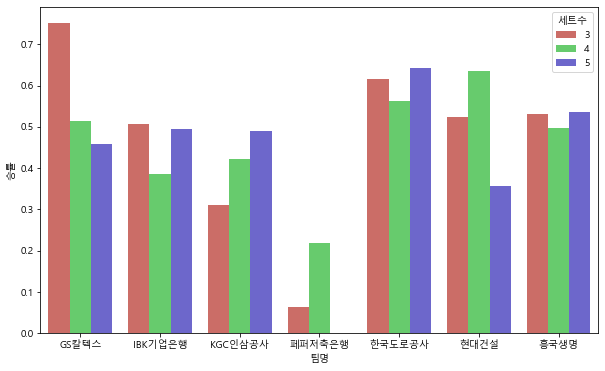

In [250]:
sns.barplot(x='팀명', y='승률', data=winning_rate, hue='세트수',palette = 'hls')
plt.show()

### 공격/수비 지표 만들기

#### 공격효율
공격 효율의 개념은 공격 성공률보다 공격수에 대한 직관적인 평가기준이 될 수 있다.  
 *세계 배구 추세도 공격 성공률보다 *공격 효율*을 훨씬 더 중시하고 있다.*   
 유럽배구연맹(CEV) 홈페이지에 방문해 보면 공격 순위를 득점-공격효율(EFF%)-공격성공률(SU%) 순으로 나열하고 있다.  
지난 8월 열린 2016 리우 하계올림픽에서는 아예 공격 성공률을 쓰지 않고, 공격 효율로 공격수 랭킹을 결정했다. (http://m.thespike.co.kr/view.php?no=3980) - 더스파이크 매거진 중

공격효율이 승패에 영향을 줄 수 있지 않을까??  
공격관련 지표들로 효율을 만들어 보자.  
- 공격효율 = {(공격 성공 개수-블로킹 차단-공격 범실)/전체 공격 시도 개수} * 100   

#### 공격 지표 추가 : 소수점 2번째 자리까지

In [251]:
''' 선수 별
오픈 공격 효율 구하기 : (오픈_성공 - 오픈_공격차단 - 오픈_범실 / 오픈_시도)
시간차 공격 효율 구하기 : (시간차_성공 - 시간차_공격차단 - 시간차_범실 / 시간차_시도)
이동 효율 구하기 : (이동_성공 - 이동_공격차단 - 이동_범실 / 이동_시도)
후위 효율 구하기 : (후위_성공 - 후위_공격차단 - 후위_범실 / 후위_시도)
속공 효율 구하기 : (속공_성공 - 속공_공격차단 - 속공_범실 / 속공_시도)
퀵오픈 효율 구하기 : (퀵오픈_성공 - 퀵오픈_공격차단 - 퀵오픈_범실 / 퀵오픈_시도)
'''
df_sub['공격종합_효율'] = round((df_sub['공격종합_성공']-df_sub['공격종합_공격차단']-df_sub['공격종합_범실']) / df_sub['공격종합_시도']*100, 2)
df_sub['오픈_효율'] = round((df_sub['오픈_성공']-df_sub['오픈_공격차단']-df_sub['오픈_범실']) / df_sub['오픈_시도']*100, 2)
df_sub['시간차_효율'] = round((df_sub['시간차_성공']-df_sub['시간차_공격차단']-df_sub['시간차_범실']) / df_sub['시간차_시도']*100, 2)
df_sub['이동_효율'] = round((df_sub['이동_성공']-df_sub['이동_공격차단']-df_sub['이동_범실']) / df_sub['이동_시도']*100, 2)
df_sub['후위_효율'] = round((df_sub['후위_성공']-df_sub['후위_공격차단']-df_sub['후위_범실']) / df_sub['후위_시도']*100, 2)
df_sub['속공_효율'] = round((df_sub['속공_성공']-df_sub['속공_공격차단']-df_sub['속공_범실']) / df_sub['속공_시도']*100, 2)
df_sub['퀵오픈_효율'] = round((df_sub['퀵오픈_성공']-df_sub['퀵오픈_공격차단']-df_sub['퀵오픈_범실']) / df_sub['퀵오픈_시도']*100, 2)
df_sub

,경기번호,팀명,경기날짜,결과,이름,득점_득점,공격종합_시도,공격종합_성공,공격종합_공격차단,공격종합_범실,...,스타팅멤버,세트수,포지션,공격종합_효율,오픈_효율,시간차_효율,이동_효율,후위_효율,속공_효율,퀵오픈_효율
0,1,IBK기업은행,2017-10-14,0,메디,24,67,20,4,2,...,1,5,L,20.90,17.07,100.00,NaN,0.00,NaN,36.36
1,1,IBK기업은행,2017-10-14,0,고예림,15,40,12,6,4,...,1,5,L,5.00,-24.00,NaN,NaN,NaN,NaN,53.33
2,1,IBK기업은행,2017-10-14,0,김희진,15,36,10,2,2,...,1,5,R,16.67,10.00,22.22,NaN,-11.11,NaN,50.00
3,1,IBK기업은행,2017-10-14,0,김미연,7,16,5,1,0,...,1,5,L,25.00,16.67,-100.00,33.33,NaN,0.00,60.00
4,1,IBK기업은행,2017-10-14,0,김수지,6,16,4,1,2,...,1,5,C,6.25,0.00,25.00,0.00,NaN,0.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10988,474,KGC인삼공사,2022-02-28,0,한송이,4,7,2,2,0,...,1,3,C,0.00,-50.00,NaN,-50.00,NaN,66.67,NaN
10989,474,KGC인삼공사,2022-02-28,0,정호영,3,5,3,1,0,...,1,3,C,40.00,33.33,NaN,NaN,NaN,50.00,NaN
10990,474,KGC인삼공사,2022-02-28,0,고의정,1,3,0,0,0,...,0,3,L,0.00,0.00,NaN,NaN,NaN,NaN,0.00
10991,474,KGC인삼공사,2022-02-28,0,하효림,1,0,0,0,0,...,0,3,S,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 수비 지표 추가 : 소수점 2번째 자리까지

In [252]:
''' 선수 별
디그 성공률 구하기 : 디그_성공/디그_시도
세트 성공률 구하기 : 세트_성공/세트_시도
리시브 성공률 구하기 : 리시브_정확/리시브_시도
블로킹 효율 구하기 : 블로킹_성공 + 블로킹_유효블락 - 블로킹_범실/블로킹_시도
'''
df_sub['디그_성공률'] = round(df_sub['디그_성공'] / df_sub['디그_시도'], 2)
df_sub['세트_성공률'] = round(df_sub['세트_성공'] / df_sub['세트_시도'], 2)
df_sub['리시브_성공률'] = round(df_sub['리시브_정확'] / df_sub['리시브_시도'], 2)
df_sub['블로킹_효율'] = round((df_sub['블로킹_성공'] + df_sub['블로킹_유효블락'] - df_sub['블로킹_범실']) / df_sub['블로킹_시도'], 2)
df_sub

,경기번호,팀명,경기날짜,결과,이름,득점_득점,공격종합_시도,공격종합_성공,공격종합_공격차단,공격종합_범실,...,오픈_효율,시간차_효율,이동_효율,후위_효율,속공_효율,퀵오픈_효율,디그_성공률,세트_성공률,리시브_성공률,블로킹_효율
0,1,IBK기업은행,2017-10-14,0,메디,24,67,20,4,2,...,17.07,100.00,NaN,0.00,NaN,36.36,0.83,0.00,0.39,0.35
1,1,IBK기업은행,2017-10-14,0,고예림,15,40,12,6,4,...,-24.00,NaN,NaN,NaN,NaN,53.33,0.77,0.14,0.60,0.70
2,1,IBK기업은행,2017-10-14,0,김희진,15,36,10,2,2,...,10.00,22.22,NaN,-11.11,NaN,50.00,0.92,0.00,NaN,0.71
3,1,IBK기업은행,2017-10-14,0,김미연,7,16,5,1,0,...,16.67,-100.00,33.33,NaN,0.00,60.00,0.83,0.00,0.00,0.33
4,1,IBK기업은행,2017-10-14,0,김수지,6,16,4,1,2,...,0.00,25.00,0.00,NaN,0.00,NaN,0.91,0.00,NaN,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10988,474,KGC인삼공사,2022-02-28,0,한송이,4,7,2,2,0,...,-50.00,NaN,-50.00,NaN,66.67,NaN,0.86,NaN,NaN,0.50
10989,474,KGC인삼공사,2022-02-28,0,정호영,3,5,3,1,0,...,33.33,NaN,NaN,NaN,50.00,NaN,1.00,NaN,NaN,0.00
10990,474,KGC인삼공사,2022-02-28,0,고의정,1,3,0,0,0,...,0.00,NaN,NaN,NaN,NaN,0.00,0.67,NaN,0.00,NaN
10991,474,KGC인삼공사,2022-02-28,0,하효림,1,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,0.67,0.41,0.00,0.50


#### 공격 지표의 극단적 수치 수정

```
case 1) 공격 수치에서 시도 횟수가 너무 적은 선수들의 성공률이 0 또는 100으로 너무 극단적이기 때문에,
시도 횟수가 1회인 사람들의 ('오픈', '시간차', '이동', '퀵오픈', '속공') 성공률을
시도 횟수가 1회인 사람들의 평균으로 수정
```

- 오픈_시도 컬럼의 극단적인 수치 학인

In [253]:

display(df_sub.loc[df['오픈_시도']==1,'오픈_성공률']. value_counts(),df_sub.loc[df['오픈_시도']==1,'오픈_성공률'].mean())

0.0      499
100.0    214
Name: 오픈_성공률, dtype: int64

30.014025245441797

In [254]:
tries = ['오픈', '시간차', '후위', '이동', '퀵오픈', '속공']
for i in tries:
    df_sub.loc[df_sub[i+'_시도']==1, i+'_성공률'] = df_sub.loc[df_sub[i+'_시도']==1,i+'_성공률'].mean()

# 속공 지표만 확인해보기
df_sub.loc[df['속공_시도']==1,['속공_시도', '속공_성공률']]

,속공_시도,속공_성공률
3,1,37.991266
27,1,37.991266
120,1,37.991266
232,1,37.991266
310,1,37.991266
...,...,...
10717,1,37.991266
10766,1,37.991266
10879,1,37.991266
10949,1,37.991266


```
case 2)
공격 / 수비 효율, 성공률 이 0 인 경우 : 공격 / 수비 시도는 있으나 성공, 공격 차단, 범실, 정확이 없는 경우
                                        or 계산식의 분자부분이 0이 되는 경우
공격 / 수비 효율, 성공률 이 NaN 인 경우 : 공격 / 수비 시도, 성공, 공격 차단, 범실, 정확 모두 없는 경우
```

In [255]:
# 공격 / 수비 효율, 성공률이 NaN 인 경우 평균값으로 변경
efficient_list = ['공격종합_효율', '오픈_효율', '시간차_효율', '이동_효율',
                  '후위_효율', '속공_효율', '퀵오픈_효율', '디그_성공률',
                  '세트_성공률', '리시브_성공률', '블로킹_효율']

df_sub[efficient_list] = df_sub[efficient_list].fillna(df_sub[efficient_list].mean())
df_sub

,경기번호,팀명,경기날짜,결과,이름,득점_득점,공격종합_시도,공격종합_성공,공격종합_공격차단,공격종합_범실,...,오픈_효율,시간차_효율,이동_효율,후위_효율,속공_효율,퀵오픈_효율,디그_성공률,세트_성공률,리시브_성공률,블로킹_효율
0,1,IBK기업은행,2017-10-14,0,메디,24,67,20,4,2,...,17.070000,100.000000,29.064791,0.000000,30.25153,36.360000,0.83,0.00000,0.390000,0.350000
1,1,IBK기업은행,2017-10-14,0,고예림,15,40,12,6,4,...,-24.000000,34.055509,29.064791,16.775562,30.25153,53.330000,0.77,0.14000,0.600000,0.700000
2,1,IBK기업은행,2017-10-14,0,김희진,15,36,10,2,2,...,10.000000,22.220000,29.064791,-11.110000,30.25153,50.000000,0.92,0.00000,0.354468,0.710000
3,1,IBK기업은행,2017-10-14,0,김미연,7,16,5,1,0,...,16.670000,-100.000000,33.330000,16.775562,0.00000,60.000000,0.83,0.00000,0.000000,0.330000
4,1,IBK기업은행,2017-10-14,0,김수지,6,16,4,1,2,...,0.000000,25.000000,0.000000,16.775562,0.00000,30.851623,0.91,0.00000,0.354468,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10988,474,KGC인삼공사,2022-02-28,0,한송이,4,7,2,2,0,...,-50.000000,34.055509,-50.000000,16.775562,66.67000,30.851623,0.86,0.23304,0.354468,0.500000
10989,474,KGC인삼공사,2022-02-28,0,정호영,3,5,3,1,0,...,33.330000,34.055509,29.064791,16.775562,50.00000,30.851623,1.00,0.23304,0.354468,0.000000
10990,474,KGC인삼공사,2022-02-28,0,고의정,1,3,0,0,0,...,0.000000,34.055509,29.064791,16.775562,30.25153,0.000000,0.67,0.23304,0.000000,0.508349
10991,474,KGC인삼공사,2022-02-28,0,하효림,1,0,0,0,0,...,19.718261,34.055509,29.064791,16.775562,30.25153,30.851623,0.67,0.41000,0.000000,0.500000


### 공격/수비지표 시각화

##### 공격 지표 시각화

In [256]:
#시각화에 사용될 득점, 공격종합_효율, 공격종합_성공률 뽑기
df_sub_vi2 = df_sub[['경기번호', '팀명', '경기날짜', '결과', '이름','득점_득점', '공격종합_효율', '공격종합_성공률']]
df_sub_vi2

,경기번호,팀명,경기날짜,결과,이름,득점_득점,공격종합_효율,공격종합_성공률
0,1,IBK기업은행,2017-10-14,0,메디,24,20.900000,29.85
1,1,IBK기업은행,2017-10-14,0,고예림,15,5.000000,30.00
2,1,IBK기업은행,2017-10-14,0,김희진,15,16.670000,27.78
3,1,IBK기업은행,2017-10-14,0,김미연,7,25.000000,31.25
4,1,IBK기업은행,2017-10-14,0,김수지,6,6.250000,25.00
...,...,...,...,...,...,...,...,...
10988,474,KGC인삼공사,2022-02-28,0,한송이,4,0.000000,28.57
10989,474,KGC인삼공사,2022-02-28,0,정호영,3,40.000000,60.00
10990,474,KGC인삼공사,2022-02-28,0,고의정,1,0.000000,0.00
10991,474,KGC인삼공사,2022-02-28,0,하효림,1,23.565582,0.00


In [257]:
## df_sub_vi2_0 : NaN값 0으로 채움
# df_sub_vi2_n : NaN값 drop
# df_sub_vi2_n : NaN값 mean()
df_sub_vi2_0 = df_sub_vi2.fillna(value=0)
df_sub_vi2_n = df_sub_vi2.dropna()
df_sub_vi2_m = df_sub_vi2.fillna(df_sub_vi2[['득점_득점','공격종합_효율','공격종합_성공률']].mean())


----------------------------- Nan값을 0,평균 값으로 채워보고, drop도 시켜 보았는데, 평균으로 채우는것이 좋아보임 ---------------------------------

c:\Users\ice_9\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\ice_9\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\ice_9\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\ice_9\anacond

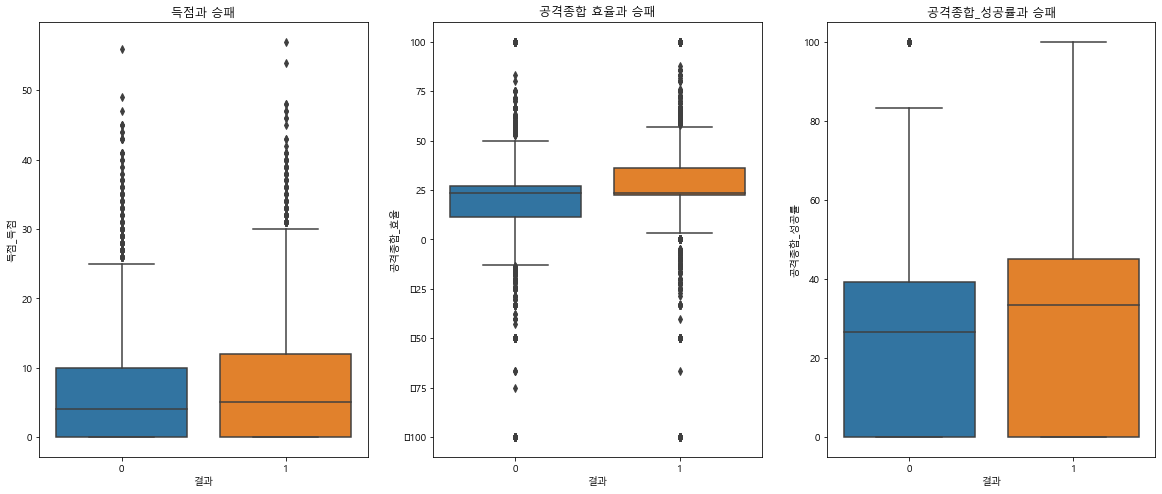

In [258]:
# 전체 데이터의 NaN값을 평균으로 채워넣은 것을 시각화
plt.figure(figsize=(20,8))

plt.subplot(1,3,1)
sns.boxplot(df_sub_vi2_m['결과'],df_sub_vi2_m['득점_득점'])
plt.title('득점과 승패')

plt.subplot(1,3,2)
sns.boxplot(df_sub_vi2_m['결과'],df_sub_vi2_m['공격종합_효율'])
plt.title('공격종합 효율과 승패')

plt.subplot(1,3,3)
sns.boxplot(df_sub_vi2_m['결과'],df_sub_vi2_m['공격종합_성공률'])
plt.title('공격종합_성공률과 승패')

plt.show()

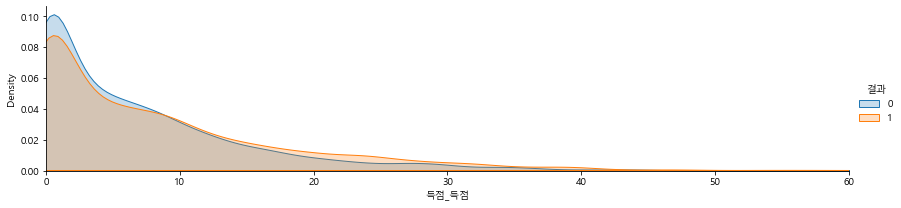

In [259]:
# 득점에 따른 결과 확인하기
facet = sns.FacetGrid(df_sub_vi2, hue="결과", aspect=4)
facet.map(sns.kdeplot,'득점_득점',shade= True)
facet.set(xlim=(0, df_sub_vi2['득점_득점'].max()))
facet.add_legend()
plt.xlim(0,60)
plt.show()

In [260]:
pd.pivot_table(df_sub_vi2, index="결과", values="득점_득점")

,득점_득점
결과,
0,6.760609
1,7.976886


c:\Users\ice_9\anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)


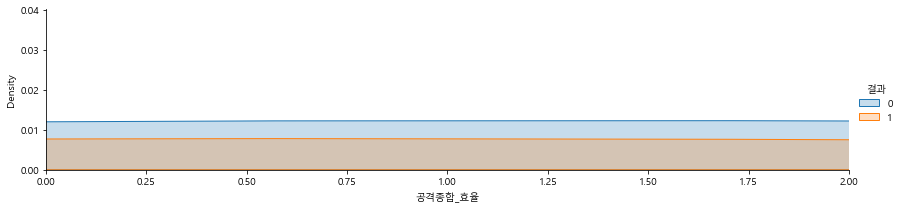

In [261]:
facet = sns.FacetGrid(df_sub_vi2, hue="결과", aspect=4)
facet.map(sns.kdeplot,'공격종합_효율',shade= True)
facet.set(xlim=(0, df_sub_vi2['공격종합_효율'].max()))
facet.add_legend()
plt.xlim(0,2)
plt.show()

In [262]:
pd.pivot_table(df_sub_vi2, index="결과", values="공격종합_효율")

,공격종합_효율
결과,
0,20.192565
1,26.853249


c:\Users\ice_9\anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)


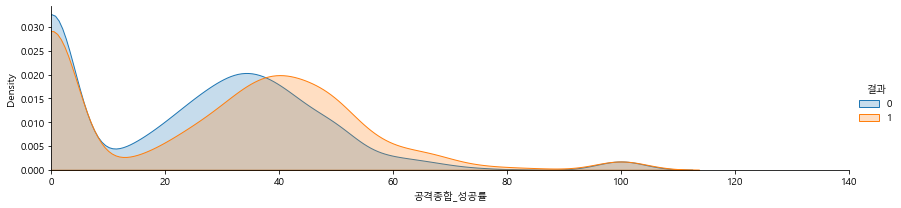

In [263]:
facet = sns.FacetGrid(df_sub_vi2, hue="결과", aspect=4)
facet.map(sns.kdeplot,'공격종합_성공률',shade= True)
facet.set(xlim=(0, df_sub_vi2['공격종합_성공률'].max()))
facet.add_legend()
plt.xlim(0,140)
plt.show()

In [264]:
pd.pivot_table(df_sub_vi2, index="결과", values="공격종합_성공률")

,공격종합_성공률
결과,
0,24.493487
1,28.502893


pair plot

c:\Users\ice_9\anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


c:\Users\ice_9\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


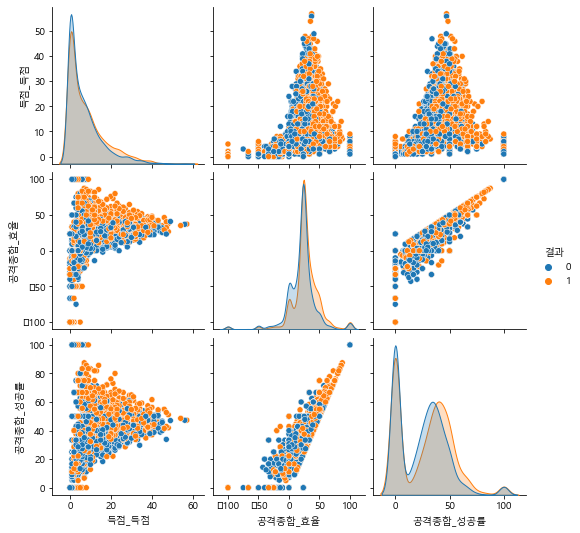

In [265]:
# 전체 경우, 공격관련 지표
#scaling과 표준화는 하지않음.
df_sub_vi2_ = df_sub_vi2[['팀명','결과','득점_득점','공격종합_효율','공격종합_성공률']]
sns.pairplot(hue='결과', data=df_sub_vi2_)

##### 수비지표 시각화

In [266]:
df_sub_vi = df_sub[['경기번호', '팀명', '경기날짜', '결과', '이름', '서브_범실', '디그_성공률', '세트_성공률', '리시브_성공률', '블로킹_효율']]
# NaN값의 처리를 위해 mean()으로 채움
df_sub_vi_m = df_sub_vi.fillna(df_sub_vi[['서브_범실','디그_성공률','세트_성공률','리시브_성공률','블로킹_효율']].mean())
df_sub_vi_m

,경기번호,팀명,경기날짜,결과,이름,서브_범실,디그_성공률,세트_성공률,리시브_성공률,블로킹_효율
0,1,IBK기업은행,2017-10-14,0,메디,3,0.83,0.00000,0.390000,0.350000
1,1,IBK기업은행,2017-10-14,0,고예림,2,0.77,0.14000,0.600000,0.700000
2,1,IBK기업은행,2017-10-14,0,김희진,3,0.92,0.00000,0.354468,0.710000
3,1,IBK기업은행,2017-10-14,0,김미연,1,0.83,0.00000,0.000000,0.330000
4,1,IBK기업은행,2017-10-14,0,김수지,1,0.91,0.00000,0.354468,0.500000
...,...,...,...,...,...,...,...,...,...,...
10988,474,KGC인삼공사,2022-02-28,0,한송이,0,0.86,0.23304,0.354468,0.500000
10989,474,KGC인삼공사,2022-02-28,0,정호영,0,1.00,0.23304,0.354468,0.000000
10990,474,KGC인삼공사,2022-02-28,0,고의정,1,0.67,0.23304,0.000000,0.508349
10991,474,KGC인삼공사,2022-02-28,0,하효림,0,0.67,0.41000,0.000000,0.500000


c:\Users\ice_9\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\ice_9\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\ice_9\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\ice_9\anacond

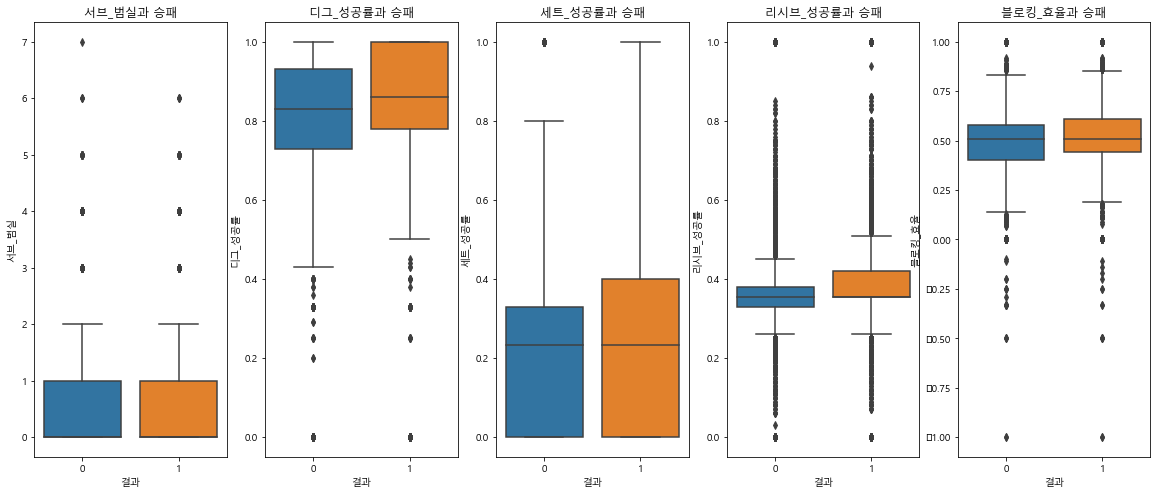

In [267]:

# 전체 컬럼의 수비적인 5개 컬럼을 subplot (각 컬럼의 Nan값을 그 컬럼의 평균 값으로 채움. )
plt.figure(figsize=(20,8))

plt.subplot(1,5,1)
sns.boxplot(df_sub_vi_m['결과'],df_sub_vi_m['서브_범실'])
plt.title('서브_범실과 승패')

plt.subplot(1,5,2)
sns.boxplot(df_sub_vi_m['결과'],df_sub_vi_m['디그_성공률'])
plt.title('디그_성공률과 승패')

plt.subplot(1,5,3)
sns.boxplot(df_sub_vi_m['결과'],df_sub_vi_m['세트_성공률'])
plt.title('세트_성공률과 승패')

plt.subplot(1,5,4)
sns.boxplot(df_sub_vi_m['결과'],df_sub_vi_m['리시브_성공률'])
plt.title('리시브_성공률과 승패')

plt.subplot(1,5,5)
sns.boxplot(df_sub_vi_m['결과'],df_sub_vi_m['블로킹_효율'])
plt.title('블로킹_효율과 승패')

plt.show()

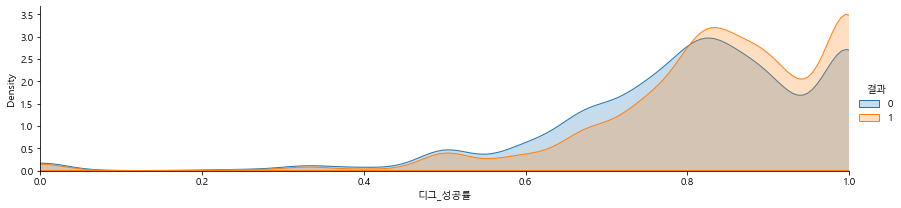

In [268]:
facet = sns.FacetGrid(df_sub_vi_m, hue="결과", aspect=4)
facet.map(sns.kdeplot,'디그_성공률',shade= True)
facet.set(xlim=(0, df_sub_vi_m['디그_성공률'].max()))
facet.add_legend()
#plt.xlim(0,140)
plt.show()

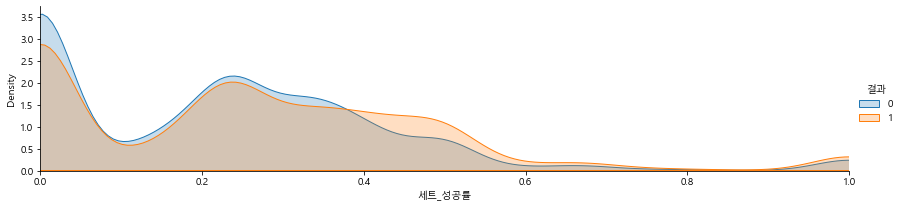

In [269]:
facet = sns.FacetGrid(df_sub_vi_m, hue="결과", aspect=4)
facet.map(sns.kdeplot,'세트_성공률',shade= True)
facet.set(xlim=(0, df_sub_vi_m['세트_성공률'].max()))
facet.add_legend()
#plt.xlim(0,140)
plt.show()

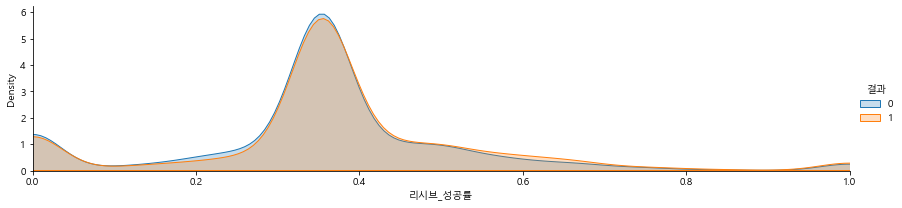

In [270]:
facet = sns.FacetGrid(df_sub_vi_m, hue="결과", aspect=4)
facet.map(sns.kdeplot,'리시브_성공률',shade= True)
facet.set(xlim=(0, df_sub_vi_m['리시브_성공률'].max()))
facet.add_legend()
#plt.xlim(0,140)
plt.show()

c:\Users\ice_9\anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)


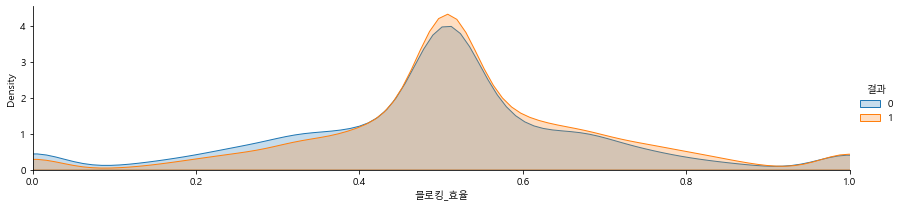

In [271]:
facet = sns.FacetGrid(df_sub_vi_m, hue="결과", aspect=4)
facet.map(sns.kdeplot,'블로킹_효율',shade= True)
facet.set(xlim=(0, df_sub_vi_m['블로킹_효율'].max()))
facet.add_legend()
#plt.xlim(0,140)
plt.show()

pair plot

c:\Users\ice_9\anaconda3\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
c:\Users\ice_9\anaconda3\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  self._figure.tight_layout(*args, **kwargs)


c:\Users\ice_9\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


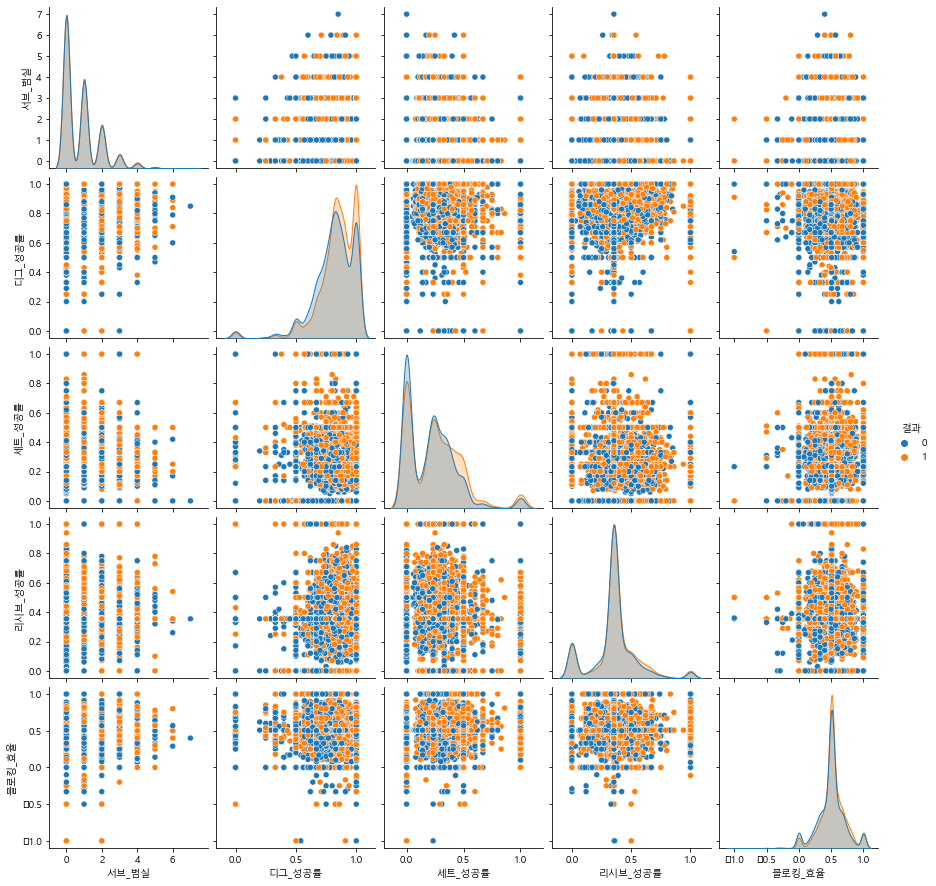

In [272]:
# 전체 경우, 수비관련 지표
#scaling과 표준화는 하지않음.
df_sub_vi1_ = df_sub_vi_m[['팀명','결과','서브_범실','디그_성공률','세트_성공률','리시브_성공률','블로킹_효율']]
sns.pairplot(hue='결과', data=df_sub_vi1_)

##### 시각화 결론
공격/수비 지표와 생성하고,  
경기 승패에 따른 공격/수비 지표들을 시각화 본 결과   
서브 범실 말고는 모든 수비지표가 승리 했을때 성공률/효율이 조금 높게 나오는 것을 알 수 있다.  
그래서 경기의 승패에 여러 지표들 성공률/효율이 영향을 미친다고 할 수 있다.  

### 필요한 컬럼선택하기

In [273]:
# 컬럼 선택

columns = [
    '경기번호',
    '경기날짜',
    '팀명',
    '결과',
    '이름',
    '공격종합_효율',
#     '득점_득점',
#     '공격종합_시도',
#     '공격종합_성공',
#     '공격종합_공격차단',
#     '공격종합_범실',
    '공격종합_성공률',
#     '공격종합_점유율',
#     '오픈_시도',
#     '오픈_성공',
#     '오픈_공격차단',
#     '오픈_범실',
    '오픈_성공률',
#     '오픈_점유율',
    '오픈_효율',
#     '시간차_시도',
#     '시간차_성공',
#     '시간차_공격차단',
#     '시간차_범실',
    '시간차_성공률',
#     '시간차_점유율',
    '시간차_효율',
#     '이동_시도',
#     '이동_성공',
#     '이동_공격차단',
#     '이동_범실',
    '이동_성공률',
#     '이동_점유율',
    '이동_효율',
#     '후위_시도',
#     '후위_성공',
#     '후위_공격차단',
#     '후위_범실',
    '후위_성공률',
#     '후위_점유율',
    '후위_효율',
#     '속공_시도',
#     '속공_성공',
#     '속공_공격차단',
#     '속공_범실',
    '속공_성공률',
#     '속공_점유율',
    '속공_효율',
#     '퀵오픈_시도',
#     '퀵오픈_성공',
#     '퀵오픈_공격차단',
#     '퀵오픈_범실',
    '퀵오픈_성공률',
#     '퀵오픈_점유율',
    '퀵오픈_효율',
#     '서브_시도',
#     '서브_성공',
    '서브_범실',
    '서브_성공률',
#     '서브_점유율',
#     '디그_시도',
#     '디그_성공',
#     '디그_실패',
#     '디그_범실',
#     '디그_세트당',
#     '디그_점유율',
    '디그_성공률',
#     '세트_시도',
#     '세트_성공',
#     '세트_범실',
#     '세트_세트당',
#     '세트_점유율',
    '세트_성공률',
#     '리시브_시도',
#     '리시브_정확',
#     '리시브_실패',
#     '리시브_세트당',
#     '리시브_점유율',
    '리시브_성공률',
#     '블로킹_시도',
#     '블로킹_성공',
#     '블로킹_유효블락',
#     '블로킹_실패',
#     '블로킹_범실',
#     '블로킹_세트당',
#     '블로킹_점유율',
#     '블로킹_어시스트',
    '블로킹_효율',
#     '벌칙_벌칙',
    '범실_범실',
    '포지션',
    '스타팅멤버',
    '세트수'
]


df_sub = df_sub[columns]

df_sub

,경기번호,경기날짜,팀명,결과,이름,공격종합_효율,공격종합_성공률,오픈_성공률,오픈_효율,시간차_성공률,...,서브_범실,서브_성공률,디그_성공률,세트_성공률,리시브_성공률,블로킹_효율,범실_범실,포지션,스타팅멤버,세트수
0,1,2017-10-14,IBK기업은행,0,메디,20.900000,29.85,26.83,17.070000,100.000000,...,3,0.20,0.83,0.00000,0.390000,0.350000,7,L,1,5
1,1,2017-10-14,IBK기업은행,0,고예림,5.000000,30.00,12.00,-24.000000,0.000000,...,2,0.60,0.77,0.14000,0.600000,0.700000,6,L,1,5
2,1,2017-10-14,IBK기업은행,0,김희진,16.670000,27.78,20.00,10.000000,44.440000,...,3,0.20,0.92,0.00000,0.354468,0.710000,6,R,1,5
3,1,2017-10-14,IBK기업은행,0,김미연,25.000000,31.25,16.67,16.670000,40.788346,...,1,0.00,0.83,0.00000,0.000000,0.330000,1,L,1,5
4,1,2017-10-14,IBK기업은행,0,김수지,6.250000,25.00,0.00,0.000000,50.000000,...,1,0.20,0.91,0.00000,0.354468,0.500000,3,C,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10988,474,2022-02-28,KGC인삼공사,0,한송이,0.000000,28.57,0.00,-50.000000,0.000000,...,0,0.00,0.86,0.23304,0.354468,0.500000,0,C,1,3
10989,474,2022-02-28,KGC인삼공사,0,정호영,40.000000,60.00,66.67,33.330000,0.000000,...,0,0.00,1.00,0.23304,0.354468,0.000000,0,C,1,3
10990,474,2022-02-28,KGC인삼공사,0,고의정,0.000000,0.00,0.00,0.000000,0.000000,...,1,0.33,0.67,0.23304,0.000000,0.508349,1,L,0,3
10991,474,2022-02-28,KGC인삼공사,0,하효림,23.565582,0.00,0.00,19.718261,0.000000,...,0,0.33,0.67,0.41000,0.000000,0.500000,0,S,0,3


### vif지표 확인 (다중공선성 확인)
 - 일반적으로 vif값이 10이상이면 다중공선성의 문제가 있다고 간주한다. 
 - 엄격하게 보는 경우 5이상

In [274]:
#formula = '결과 ~' + '+ '.join(df_sub.columns[:-1])
#formula
y, X = dmatrices('결과 ~ 공격종합_성공률 + 공격종합_효율 + 속공_성공률 + 속공_효율 + 시간차_성공률 + 시간차_효율 + 이동_성공률 + 이동_효율 + 후위_성공률 + 후위_효율 + 퀵오픈_성공률 + 퀵오픈_효율+ 서브_범실 + 서브_성공률 + 디그_성공률 + 세트_성공률 + 리시브_성공률 + 블로킹_효율 + 범실_범실 + 세트수',
                 data=df_sub ,return_type='dataframe')
df_vif = pd.DataFrame()
df_vif['colname'] = X.columns
df_vif['VIF'] = [vif(X.values, i) for i in range(X.shape[1])]
df_vif 

,colname,VIF
0,Intercept,69.334006
1,공격종합_성공률,3.338488
2,공격종합_효율,2.480415
3,속공_성공률,2.115611
4,속공_효율,1.402232
5,시간차_성공률,1.363979
6,시간차_효율,1.111466
7,이동_성공률,1.502209
8,이동_효율,1.182046
9,후위_성공률,1.993116


- 위의 결과로 크게 다중공선성의 문제가 있다고 확인되지 않음.

In [275]:
df_sub.columns

Index(['경기번호', '경기날짜', '팀명', '결과', '이름', '공격종합_효율', '공격종합_성공률', '오픈_성공률',
       '오픈_효율', '시간차_성공률', '시간차_효율', '이동_성공률', '이동_효율', '후위_성공률', '후위_효율',
       '속공_성공률', '속공_효율', '퀵오픈_성공률', '퀵오픈_효율', '서브_범실', '서브_성공률', '디그_성공률',
       '세트_성공률', '리시브_성공률', '블로킹_효율', '범실_범실', '포지션', '스타팅멤버', '세트수'],
      dtype='object')

### 홈 / 어웨이 진영 컬럼 추가 - 크게 상관 없는듯.. 유의미한 지표 X

In [276]:
# 경기 번호, 팀명, 결과에 따른 팀원 전체의 평균 성공률, 효율
temp = df_sub.groupby(['경기번호', '팀명', '결과']).mean()

# 팀원 전체에 대한 평균으로 진행하므로 득점점유율과, 스타팅멤버 컬럼 제거
temp.drop(['득점점유율', '스타팅멤버'], 1, inplace=True)
temp.reset_index(inplace=True)
temp

C:\Users\ice_9\AppData\Local\Temp\ipykernel_16092\1552097474.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  temp.drop(['득점점유율', '스타팅멤버'], 1, inplace=True)


KeyError: "['득점점유율'] not found in axis"

In [ ]:
# 홈인 경우 1, 어웨이인 경우 0
# 전체를 홈이라고 지정 -> index가 홀수 인 경우(같은 경기번호에서 뒤에 있는 경우) 어웨이로 변경
temp['진영'] = 1
temp.loc[temp.index % 2 == 1, '진영'] = 0
temp

,경기번호,팀명,결과,공격종합_성공률,오픈_성공률,오픈_효율,시간차_성공률,시간차_효율,이동_성공률,이동_효율,...,퀵오픈_효율,서브_범실,서브_성공률,디그_성공률,세트_성공률,리시브_성공률,블로킹_효율,범실_범실,세트수,진영
0,1,IBK기업은행,0,17.985000,9.437500,-0.657500,24.305000,5.902500,7.291250,4.166250,...,24.961250,1.250000,0.175000,0.857500,0.128750,0.162500,0.395000,3.125000,5.0,1
1,1,흥국생명,1,12.320000,6.898182,-3.912727,10.605455,10.605455,3.636364,1.818182,...,13.636364,0.909091,0.127273,0.876364,0.203636,0.275455,0.507273,2.454545,5.0,0
2,2,KGC인삼공사,0,32.868889,35.226667,24.852222,3.703333,3.703333,2.777778,2.777778,...,7.036667,0.444444,0.122222,0.846667,0.200000,0.297778,0.446667,1.444444,5.0,1
3,2,현대건설,1,20.770000,14.957778,11.331111,20.712222,18.490000,0.000000,0.000000,...,12.602222,1.444444,0.111111,0.815556,0.158889,0.173333,0.308889,3.222222,5.0,0
4,3,GS칼텍스,1,27.587273,22.803636,15.679091,15.909091,15.909091,0.000000,0.000000,...,7.139091,1.000000,0.163636,0.847273,0.200909,0.231818,0.350000,2.272727,5.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,472,흥국생명,0,23.755714,20.237143,5.634286,0.000000,0.000000,0.000000,-7.142857,...,16.327143,0.285714,0.142857,0.828571,0.170000,0.095714,0.270000,2.142857,3.0,0
944,473,페퍼저축은행,0,21.275714,29.907143,24.785714,9.524286,9.524286,0.000000,0.000000,...,8.571429,0.428571,0.047143,0.790000,0.081429,0.124286,0.338571,1.142857,3.0,1
945,473,한국도로공사,1,38.804286,33.334286,27.552857,20.000000,20.000000,14.285714,14.285714,...,21.502857,1.000000,0.188571,0.852857,0.204286,0.408571,0.384286,1.428571,3.0,0
946,474,GS칼텍스,1,45.481250,31.101250,18.601250,12.500000,12.500000,12.500000,12.500000,...,0.087500,0.750000,0.208750,0.833750,0.408750,0.302500,0.401250,0.875000,3.0,1


In [ ]:
df_team = temp[['경기번호', '팀명', '진영']]
df_team

,경기번호,팀명,진영
0,1,IBK기업은행,1
1,1,흥국생명,0
2,2,KGC인삼공사,1
3,2,현대건설,0
4,3,GS칼텍스,1
...,...,...,...
943,472,흥국생명,0
944,473,페퍼저축은행,1
945,473,한국도로공사,0
946,474,GS칼텍스,1


### 데이터 변경
- A, B팀의 스타팅 멤버들의 직전 경기력으로 승패 예측

In [ ]:
df=df_sub.copy()
# 경기날짜의 데이터타입 변경 (datetime64)
df['경기날짜'] = df['경기날짜'].astype('datetime64')
df.dtypes

경기번호                 int64
경기날짜        datetime64[ns]
팀명                  object
결과                   int64
이름                  object
공격종합_효율            float64
공격종합_성공률           float64
오픈_성공률             float64
오픈_효율              float64
시간차_성공률            float64
시간차_효율             float64
이동_성공률             float64
이동_효율              float64
후위_성공률             float64
후위_효율              float64
속공_성공률             float64
속공_효율              float64
퀵오픈_성공률            float64
퀵오픈_효율             float64
서브_범실                int64
서브_성공률             float64
디그_성공률             float64
세트_성공률             float64
리시브_성공률            float64
블로킹_효율             float64
범실_범실                int64
포지션                 object
득점점유율              float64
스타팅멤버                int64
세트수                  int64
dtype: object

In [ ]:
df['스타팅멤버']=1
# 한 경기당 스타팅멤버의 수 확인
df.groupby(['경기날짜', '팀명'])['스타팅멤버'].sum().reset_index()['스타팅멤버'].unique()

array([ 8, 11,  9, 10,  6,  7,  5, 12], dtype=int64)

In [ ]:
# 스타팅멤버만 선택
df_starting = df[df['스타팅멤버'] == 1]
df_starting

,경기번호,경기날짜,팀명,결과,이름,공격종합_효율,공격종합_성공률,오픈_성공률,오픈_효율,시간차_성공률,...,서브_성공률,디그_성공률,세트_성공률,리시브_성공률,블로킹_효율,범실_범실,포지션,득점점유율,스타팅멤버,세트수
0,1,2017-10-14,IBK기업은행,0,메디,20.900000,29.85,26.83,17.070000,100.00,...,0.20,0.83,0.00000,0.390000,0.350000,7,L,0.000401,1,5
1,1,2017-10-14,IBK기업은행,0,고예림,5.000000,30.00,12.00,-24.000000,0.00,...,0.60,0.77,0.14000,0.600000,0.700000,6,L,0.000251,1,5
2,1,2017-10-14,IBK기업은행,0,김희진,16.670000,27.78,20.00,10.000000,44.44,...,0.20,0.92,0.00000,0.354468,0.710000,6,R,0.000251,1,5
3,1,2017-10-14,IBK기업은행,0,김미연,25.000000,31.25,16.67,16.670000,0.00,...,0.00,0.83,0.00000,0.000000,0.330000,1,L,0.000117,1,5
4,1,2017-10-14,IBK기업은행,0,김수지,6.250000,25.00,0.00,0.000000,50.00,...,0.20,0.91,0.00000,0.354468,0.500000,3,C,0.000100,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10988,474,2022-02-28,KGC인삼공사,0,한송이,0.000000,28.57,0.00,-50.000000,0.00,...,0.00,0.86,0.23304,0.354468,0.500000,0,C,0.000067,1,3
10989,474,2022-02-28,KGC인삼공사,0,정호영,40.000000,60.00,66.67,33.330000,0.00,...,0.00,1.00,0.23304,0.354468,0.000000,0,C,0.000050,1,3
10990,474,2022-02-28,KGC인삼공사,0,고의정,0.000000,0.00,0.00,0.000000,0.00,...,0.33,0.67,0.23304,0.000000,0.508349,1,L,0.000017,1,3
10991,474,2022-02-28,KGC인삼공사,0,하효림,23.565582,0.00,0.00,19.718261,0.00,...,0.33,0.67,0.41000,0.000000,0.500000,0,S,0.000017,1,3


In [ ]:
## 경기 당 스타팅멤버가 5명 이상만 선택

# 스타팅멤버가 5명 미만이 포함된 날짜 선택
temp = (df_starting.groupby(['경기날짜', '팀명'])[['스타팅멤버']].sum() < 5).reset_index()
drop_dates = temp.loc[temp['스타팅멤버'], '경기날짜'].unique()

# drop_dates를 제외한 날짜만 선택
df_starting = df_starting[~df_starting['경기날짜'].isin(drop_dates)]

# 스타팅멤버 다시 확인
df_starting.groupby(['경기날짜', '팀명'])['스타팅멤버'].sum().value_counts()

9     280
8     276
10    175
7     133
11     39
6      32
5      10
12      3
Name: 스타팅멤버, dtype: int64

In [ ]:
# 데이터프레임 변경 (날짜, 팀 별 출전 선수 명단과 결과)
df_starting5 = df_starting.groupby(['경기날짜', '팀명'])[['이름', '결과']].agg({'이름' : lambda data : ' '.join(data).split(), '결과' : any})
df_starting5 = pd.DataFrame(df_starting5).reset_index()
df_starting5['이름'] = df_starting5['이름'].str[:5]
df_starting5.head()

,경기날짜,팀명,이름,결과
0,2017-10-14,IBK기업은행,"[메디, 고예림, 김희진, 김미연, 김수지]",False
1,2017-10-14,흥국생명,"[심슨, 이재영, 정시영, 이한비, 김나희]",True
2,2017-10-15,KGC인삼공사,"[알레나, 한송이, 유희옥, 최수빈, 이재은]",False
3,2017-10-15,현대건설,"[엘리자베스, 황연주, 양효진, 김세영, 황민경]",True
4,2017-10-17,GS칼텍스,"[강소휘, 듀크, 표승주, 문명화, 김유리]",True


In [ ]:
df_starting.head()

,경기번호,경기날짜,팀명,결과,이름,공격종합_효율,공격종합_성공률,오픈_성공률,오픈_효율,시간차_성공률,...,서브_성공률,디그_성공률,세트_성공률,리시브_성공률,블로킹_효율,범실_범실,포지션,득점점유율,스타팅멤버,세트수
0,1,2017-10-14,IBK기업은행,0,메디,20.90,29.85,26.83,17.07,100.00,...,0.2,0.83,0.00,0.390000,0.35,7,L,0.000401,1,5
1,1,2017-10-14,IBK기업은행,0,고예림,5.00,30.00,12.00,-24.00,0.00,...,0.6,0.77,0.14,0.600000,0.70,6,L,0.000251,1,5
2,1,2017-10-14,IBK기업은행,0,김희진,16.67,27.78,20.00,10.00,44.44,...,0.2,0.92,0.00,0.354468,0.71,6,R,0.000251,1,5
3,1,2017-10-14,IBK기업은행,0,김미연,25.00,31.25,16.67,16.67,0.00,...,0.0,0.83,0.00,0.000000,0.33,1,L,0.000117,1,5
4,1,2017-10-14,IBK기업은행,0,김수지,6.25,25.00,0.00,0.00,50.00,...,0.2,0.91,0.00,0.354468,0.50,3,C,0.000100,1,5


In [ ]:
# 경기번호 추가
total = df_starting5.shape[0] // 2
df_starting5['경기번호'] = np.array([[i,i] for i in range(1, total+1)]).flatten()
df_starting5.head()

,경기날짜,팀명,이름,결과,경기번호
0,2017-10-14,IBK기업은행,"[메디, 고예림, 김희진, 김미연, 김수지]",False,1
1,2017-10-14,흥국생명,"[심슨, 이재영, 정시영, 이한비, 김나희]",True,1
2,2017-10-15,KGC인삼공사,"[알레나, 한송이, 유희옥, 최수빈, 이재은]",False,2
3,2017-10-15,현대건설,"[엘리자베스, 황연주, 양효진, 김세영, 황민경]",True,2
4,2017-10-17,GS칼텍스,"[강소휘, 듀크, 표승주, 문명화, 김유리]",True,3


In [ ]:
# 데이터프레임 변경 (경기 별 두 팀의 이름, 출전 선수 명단과 결과)
def concat_names(data) :
    result = []
    for d in data :
        result += d
    return result
df_game = df_starting5.groupby('경기번호').agg({'경기날짜' : lambda dates : dates.values[0],
                                                '팀명' : lambda teams : ' vs '.join(teams),
                                                '이름' : concat_names,
                                                '결과' : np.argmax}).reset_index()
df_game

,경기번호,경기날짜,팀명,이름,결과
0,1,2017-10-14,IBK기업은행 vs 흥국생명,"[메디, 고예림, 김희진, 김미연, 김수지, 심슨, 이재영, 정시영, 이한비, 김나희]",1
1,2,2017-10-15,KGC인삼공사 vs 현대건설,"[알레나, 한송이, 유희옥, 최수빈, 이재은, 엘리자베스, 황연주, 양효진, 김세영...",1
2,3,2017-10-17,GS칼텍스 vs 한국도로공사,"[강소휘, 듀크, 표승주, 문명화, 김유리, 이바나, 박정아, 정대영, 배유나, 최은지]",0
3,4,2017-10-18,IBK기업은행 vs 현대건설,"[메디, 김희진, 고예림, 김수지, 이고은, 엘리자베스, 양효진, 황연주, 김세영,...",1
4,5,2017-10-21,KGC인삼공사 vs 흥국생명,"[알레나, 한송이, 유희옥, 한수지, 최수빈, 심슨, 이재영, 정시영, 김나희, 임해정]",1
...,...,...,...,...,...
469,470,2022-02-24,GS칼텍스 vs 페퍼저축은행,"[모마, 유서연, 최은지, 문명화, 오지영, 엘리자벳, 이한비, 박경현, 하혜진, ...",0
470,471,2022-02-25,KGC인삼공사 vs 현대건설,"[옐레나, 박혜민, 정호영, 이소영, 한송이, 야스민, 양효진, 정지윤, 이다현, ...",0
471,472,2022-02-26,IBK기업은행 vs 흥국생명,"[표승주, 김희진, 산타나, 김수지, 최정민, 캣벨, 김미연, 정윤주, 이주아, 김채연]",0
472,473,2022-02-27,페퍼저축은행 vs 한국도로공사,"[박경현, 하혜진, 엘리자벳, 최가은, 구솔, 켈시, 박정아, 배유나, 전새얀, 정대영]",1


### 각 선수의 직전 5번 기록(최근 폼)에 따라 데이터셋을 만들자!



여러 데이터들의 컬럼생성, 시각화를 진행 해 본 결과  
모든시즌의 데이터를 확인 하지 말고,  
최근 기록들(최근 폼)의 데이터셋을 만들어 보기로 함.  


#### 선수의 직전 5번의 기록 찾는 함수

In [ ]:
# 선수의 직전 5개의 기록 찾는 함수 정의
def find_five_previous_record(df, date, name) :
    day1 = pd.Timedelta(days=1)
    date -= day1
    
    while date >= df.loc[0, '경기날짜'] :
        row = df[(df['경기날짜'] <= date) & (df['이름'] == name)]
        if len(row) : # 이전 기록 존재
            return row.iloc[-5:, :]
        date -= day1
    else : # 이전 기록 존재 x
        return []

In [ ]:
# 각 선수 별 5번 직전 기록을 새로운 열에 추가
cols = ['공격종합_효율', '공격종합_성공률','오픈_성공률','시간차_성공률','이동_성공률','후위_성공률','속공_성공률',
        '퀵오픈_성공률','서브_성공률','범실_범실', '오픈_효율', '시간차_효율', '이동_효율',
        '후위_효율','속공_효율', '퀵오픈_효율', '디그_성공률', '세트_성공률', '리시브_성공률', '블로킹_효율', '세트수']

rows = []
for i in range(len(df_game)) :
    date = df_game.loc[i, '경기날짜']
    names = df_game.loc[i, '이름']
    row = []
    
    for name in names :
        result = find_five_previous_record(df, date, name)
        if len(result) == 0 :
            row += [np.nan] * len(cols)
        else :
            row += list(result[cols].values.mean(axis=0).flatten())
    rows.append(row)

    
columns = []
for team in ['A팀', 'B팀'] :
    for player in ['선수1', '선수2', '선수3', '선수4', '선수5'] :
        columns += [f'{team}_{player}_{col}' for col in cols]
        
df_game5 = pd.concat([df_game, pd.DataFrame(rows, columns = columns)], axis = 1)
df_game5.tail()

,경기번호,경기날짜,팀명,이름,결과,A팀_선수1_공격종합_효율,A팀_선수1_공격종합_성공률,A팀_선수1_오픈_성공률,A팀_선수1_시간차_성공률,A팀_선수1_이동_성공률,...,B팀_선수5_시간차_효율,B팀_선수5_이동_효율,B팀_선수5_후위_효율,B팀_선수5_속공_효율,B팀_선수5_퀵오픈_효율,B팀_선수5_디그_성공률,B팀_선수5_세트_성공률,B팀_선수5_리시브_성공률,B팀_선수5_블로킹_효율,B팀_선수5_세트수
469,470,2022-02-24,GS칼텍스 vs 페퍼저축은행,"[모마, 유서연, 최은지, 문명화, 오지영, 엘리자벳, 이한비, 박경현, 하혜진, ...",0,37.544,51.064,50.692,60.000,0.0,...,-13.188898,55.812958,16.775562,11.00000,30.851623,0.600,0.086608,0.212681,0.606,3.4
470,471,2022-02-25,KGC인삼공사 vs 현대건설,"[옐레나, 박혜민, 정호영, 이소영, 한송이, 야스민, 양효진, 정지윤, 이다현, ...",0,23.938,38.274,30.596,20.000,0.0,...,33.334000,29.064791,30.065337,30.25153,31.350000,0.904,0.034000,0.368000,0.760,3.8
471,472,2022-02-26,IBK기업은행 vs 흥국생명,"[표승주, 김희진, 산타나, 김수지, 최정민, 캣벨, 김미연, 정윤주, 이주아, 김채연]",0,30.280,40.182,36.546,20.000,0.0,...,20.288204,-2.561126,16.775562,-2.00000,30.851623,0.910,0.346608,0.141787,0.534,3.4
472,473,2022-02-27,페퍼저축은행 vs 한국도로공사,"[박경현, 하혜진, 엘리자벳, 최가은, 구솔, 켈시, 박정아, 배유나, 전새얀, 정대영]",1,24.614,38.518,31.950,10.000,0.0,...,34.055509,29.064791,16.775562,11.66600,30.851623,0.822,0.300000,0.241787,0.466,3.6
473,474,2022-02-28,GS칼텍스 vs KGC인삼공사,"[모마, 유서연, 최은지, 문명화, 안혜진, 옐레나, 이소영, 박혜민, 한송이, 정호영]",0,43.472,54.190,56.358,46.666,0.0,...,20.433305,29.064791,16.775562,55.55600,30.851623,0.910,0.150000,0.612681,0.462,4.0


In [ ]:
# '경기번호', '경기날짜', '팀명', '이름' 열 삭제
data5 = df_game5.drop(['경기번호', '경기날짜', '팀명', '이름'], axis = 1)
data5

,결과,A팀_선수1_공격종합_효율,A팀_선수1_공격종합_성공률,A팀_선수1_오픈_성공률,A팀_선수1_시간차_성공률,A팀_선수1_이동_성공률,A팀_선수1_후위_성공률,A팀_선수1_속공_성공률,A팀_선수1_퀵오픈_성공률,A팀_선수1_서브_성공률,...,B팀_선수5_시간차_효율,B팀_선수5_이동_효율,B팀_선수5_후위_효율,B팀_선수5_속공_효율,B팀_선수5_퀵오픈_효율,B팀_선수5_디그_성공률,B팀_선수5_세트_성공률,B팀_선수5_리시브_성공률,B팀_선수5_블로킹_효율,B팀_선수5_세트수
0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,20.900,29.850,26.830,100.000,0.0,8.330,0.0,45.450,0.200,...,20.000000,29.064791,0.000000,30.25153,27.270000,0.870,0.170000,0.580000,0.550,5.0
4,1,26.850,38.890,37.700,0.000,0.0,40.000,0.0,50.000,0.000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,0,37.544,51.064,50.692,60.000,0.0,54.122,0.0,27.324,0.500,...,-13.188898,55.812958,16.775562,11.00000,30.851623,0.600,0.086608,0.212681,0.606,3.4
470,0,23.938,38.274,30.596,20.000,0.0,42.434,0.0,51.478,0.232,...,33.334000,29.064791,30.065337,30.25153,31.350000,0.904,0.034000,0.368000,0.760,3.8
471,0,30.280,40.182,36.546,20.000,0.0,0.000,0.0,44.066,0.132,...,20.288204,-2.561126,16.775562,-2.00000,30.851623,0.910,0.346608,0.141787,0.534,3.4
472,1,24.614,38.518,31.950,10.000,0.0,20.000,0.0,67.000,0.182,...,34.055509,29.064791,16.775562,11.66600,30.851623,0.822,0.300000,0.241787,0.466,3.6


In [ ]:
# 결측치 제거
data = data5.dropna()
data

,결과,A팀_선수1_공격종합_효율,A팀_선수1_공격종합_성공률,A팀_선수1_오픈_성공률,A팀_선수1_시간차_성공률,A팀_선수1_이동_성공률,A팀_선수1_후위_성공률,A팀_선수1_속공_성공률,A팀_선수1_퀵오픈_성공률,A팀_선수1_서브_성공률,...,B팀_선수5_시간차_효율,B팀_선수5_이동_효율,B팀_선수5_후위_효율,B팀_선수5_속공_효율,B팀_선수5_퀵오픈_효율,B팀_선수5_디그_성공률,B팀_선수5_세트_성공률,B팀_선수5_리시브_성공률,B팀_선수5_블로킹_효율,B팀_선수5_세트수
3,1,20.900,29.850,26.830,100.000,0.0,8.330,0.0,45.450,0.200,...,20.000000,29.064791,0.000000,30.251530,27.270000,0.870000,0.170000,0.580000,0.550000,5.000000
5,0,24.535,36.755,30.520,66.665,0.0,33.575,0.0,49.650,0.100,...,34.055509,29.064791,16.775562,30.251530,30.851623,0.810000,0.410000,0.000000,0.750000,5.000000
6,1,21.570,35.290,42.860,25.000,0.0,37.500,0.0,18.180,0.000,...,17.027754,29.064791,16.775562,30.251530,4.545000,0.845000,0.245000,0.450000,0.535000,5.000000
7,0,28.920,40.970,35.440,30.000,0.0,46.740,0.0,45.000,0.100,...,34.055509,29.064791,16.775562,30.251530,30.851623,0.945000,0.355000,0.354468,0.625000,5.000000
8,1,33.095,44.570,44.155,12.500,0.0,54.860,0.0,37.660,0.125,...,50.000000,29.064791,16.775562,63.703333,30.851623,0.853333,0.244347,0.236312,0.576667,4.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,0,37.544,51.064,50.692,60.000,0.0,54.122,0.0,27.324,0.500,...,-13.188898,55.812958,16.775562,11.000000,30.851623,0.600000,0.086608,0.212681,0.606000,3.400000
470,0,23.938,38.274,30.596,20.000,0.0,42.434,0.0,51.478,0.232,...,33.334000,29.064791,30.065337,30.251530,31.350000,0.904000,0.034000,0.368000,0.760000,3.800000
471,0,30.280,40.182,36.546,20.000,0.0,0.000,0.0,44.066,0.132,...,20.288204,-2.561126,16.775562,-2.000000,30.851623,0.910000,0.346608,0.141787,0.534000,3.400000
472,1,24.614,38.518,31.950,10.000,0.0,20.000,0.0,67.000,0.182,...,34.055509,29.064791,16.775562,11.666000,30.851623,0.822000,0.300000,0.241787,0.466000,3.600000


### 데이터 분리

In [277]:
# 결과 열을 제외한 열은 X, 결과 열은 y에 저장
X = data.drop('결과', axis = 1)
y = data['결과']

In [278]:
# 학습, 검증 데이터 분리
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=200, stratify=y)

In [280]:
# 분리된 데이터 확인 (훈련데이터)
X_train.head(2)

,A팀_선수1_공격종합_효율,A팀_선수1_공격종합_성공률,A팀_선수1_오픈_성공률,A팀_선수1_시간차_성공률,A팀_선수1_이동_성공률,A팀_선수1_후위_성공률,A팀_선수1_속공_성공률,A팀_선수1_퀵오픈_성공률,A팀_선수1_서브_성공률,A팀_선수1_범실_범실,...,B팀_선수5_시간차_효율,B팀_선수5_이동_효율,B팀_선수5_후위_효율,B팀_선수5_속공_효율,B팀_선수5_퀵오픈_효율,B팀_선수5_디그_성공률,B팀_선수5_세트_성공률,B팀_선수5_리시브_성공률,B팀_선수5_블로킹_효율,B팀_선수5_세트수
471,30.280,40.182,36.546,20.0,0.0,0.000,0.0,44.066,0.132,1.8,...,20.288204,-2.561126,16.775562,-2.00000,30.851623,0.910,0.346608,0.141787,0.534,3.4
119,35.502,48.488,52.858,20.0,0.0,42.992,0.0,41.730,0.172,3.6,...,26.811102,29.064791,16.775562,30.25153,51.170325,0.834,0.388000,0.496000,0.698,4.0


### 모델링 (random_state=0 으로 통일)

In [281]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

my_predictions = {}
my_pred = None
my_actual = None
my_name = None

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive', 
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray', 
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
         ]

def plot_predictions(name_, pred, actual):
    df = pd.DataFrame({'prediction': pred, 'actual': y_test})
    df = df.sort_values(by='actual').reset_index(drop=True)

    plt.figure(figsize=(11, 8))
    plt.scatter(df.index, df['prediction'], marker='x', color='r')
    plt.scatter(df.index, df['actual'], alpha=0.7, marker='o', color='black')
    plt.title(name_, fontsize=15)
    plt.legend(['prediction', 'actual'], fontsize=12)
    plt.show()

def f1_eval(name_, pred, actual):
    global my_predictions, colors, my_pred, my_actual, my_name
    
    my_name = name_
    my_pred = pred
    my_actual = actual

    plot_predictions(name_, pred, actual)

    f1 = f1_score(actual, pred)
    my_predictions[name_] = f1

    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(y_value, columns=['model', 'f1'])
    print(df)
    min_ = 0
    max_ = 1
    
    length = len(df) / 2
    
    plt.figure(figsize=(9, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=12)
    bars = ax.barh(np.arange(len(df)), df['f1'], height=0.3)
    
    for i, v in enumerate(df['f1']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=12, fontweight='bold', verticalalignment='center')
        
    plt.title('F1 Score', fontsize=16)
    plt.xlim(min_, max_)
    
    plt.show()
    
def add_model(name_, pred, actual):
    global my_predictions, my_pred, my_actual, my_name
    my_name = name_
    my_pred = pred
    my_actual = actual
    
    f1 = f1_score(actual, pred)
    my_predictions[name_] = f1

def remove_model(name_):
    global my_predictions
    try:
        del my_predictions[name_]
    except KeyError:
        return False
    return True

def plot_all():
    global my_predictions, my_pred, my_actual, my_name
    
    plot_predictions(my_name, my_pred, my_actual)
    
    y_value = sorted(my_predictions.items(), key=lambda x: x[1], reverse=True)
    
    df = pd.DataFrame(y_value, columns=['model', 'f1'])
    print(df)
    min_ = 0
    max_ = 1
    
    length = len(df) / 2
    
    plt.figure(figsize=(9, length))
    ax = plt.subplot()
    ax.set_yticks(np.arange(len(df)))
    ax.set_yticklabels(df['model'], fontsize=12)
    bars = ax.barh(np.arange(len(df)), df['f1'], height=0.3)
    
    for i, v in enumerate(df['f1']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax.text(v + 2, i, str(round(v, 3)), color='k', fontsize=12, fontweight='bold', verticalalignment='center')
        
    plt.title('F1 Score', fontsize=16)
    plt.xlim(min_, max_)
    
    plt.show()

In [282]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

0.779 0.617


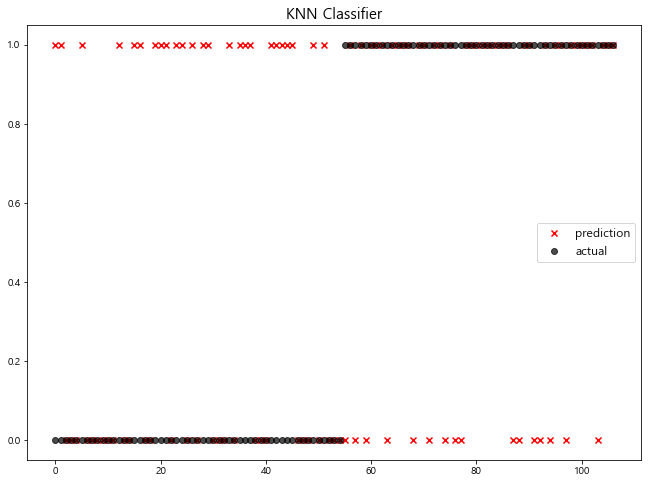

            model        f1
0  KNN Classifier  0.637168


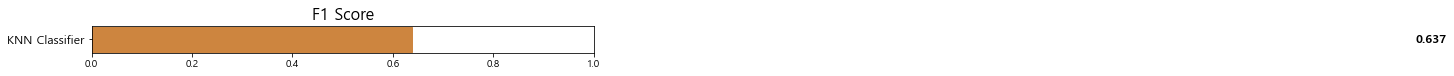

In [284]:
# KNN classifier (K=3)
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
print(knn.score(X_train, y_train).round(3), knn.score(X_test, y_test).round(3))
f1_eval('KNN Classifier', pred, y_test)

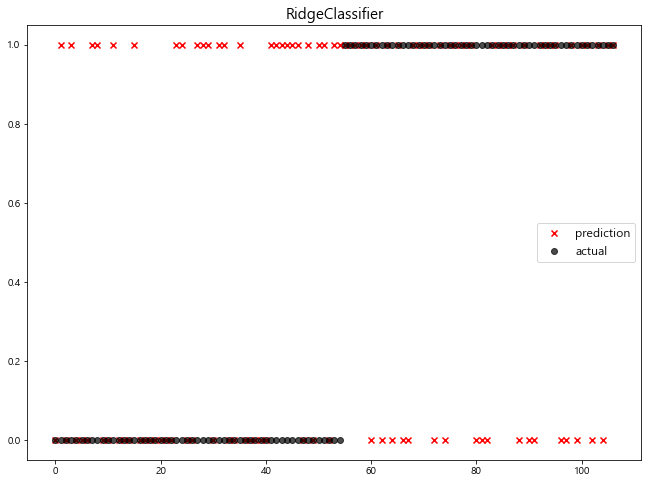

             model        f1
0   KNN Classifier  0.637168
1  RidgeClassifier  0.612613


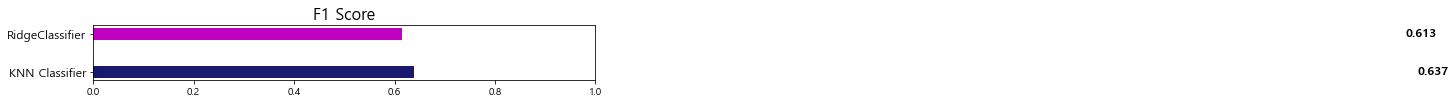

In [285]:
# RidgeCalssifier (alpha=1)
from sklearn.linear_model import RidgeClassifier

ridge = RidgeClassifier(alpha=1)
ridge.fit(X_train, y_train)
pred = ridge.predict(X_test)
f1_eval('RidgeClassifier', pred, y_test)

0.916 0.598


c:\Users\ice_9\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


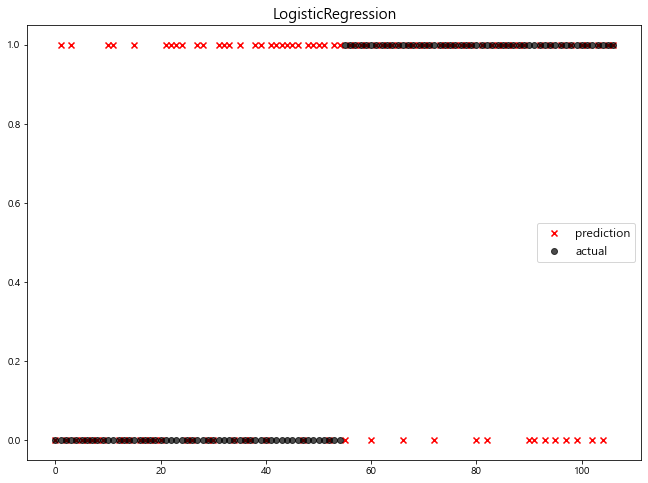

                model        f1
0  LogisticRegression  0.638655
1      KNN Classifier  0.637168
2     RidgeClassifier  0.612613


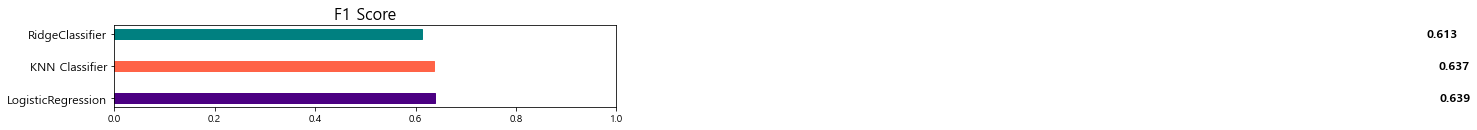

In [286]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression(random_state=0)
lg.fit(X_train, y_train)
pred = lg.predict(X_test)
print(lg.score(X_train, y_train).round(3), lg.score(X_test, y_test).round(3))
f1_eval('LogisticRegression', pred, y_test)

0.885 0.514


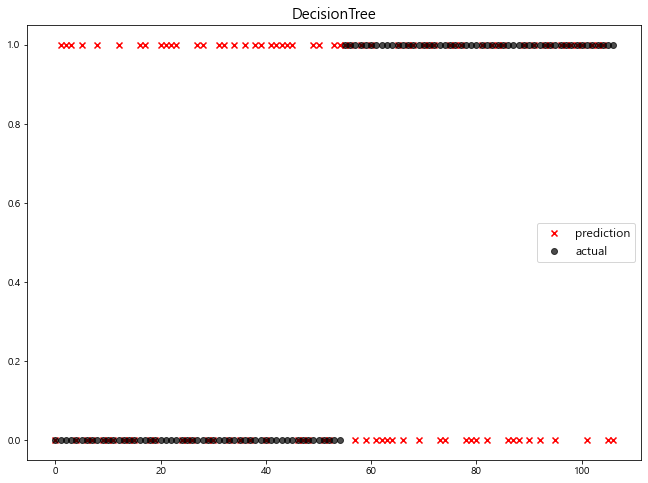

                model        f1
0  LogisticRegression  0.638655
1      KNN Classifier  0.637168
2     RidgeClassifier  0.612613
3        DecisionTree  0.527273


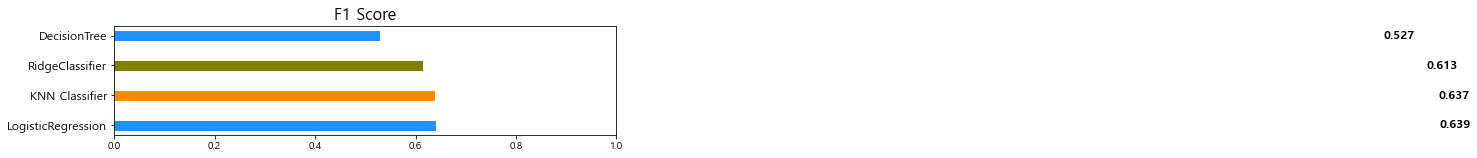

In [288]:
# DecisionTree (max_depth = 5, max_features=0.8)
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=0,max_depth = 5, max_features=0.8)
tree.fit(X_train, y_train)
pred = tree.predict(X_test)
print(tree.score(X_train, y_train).round(3), tree.score(X_test, y_test).round(3))
f1_eval('DecisionTree', pred, y_test)

0.991 0.636


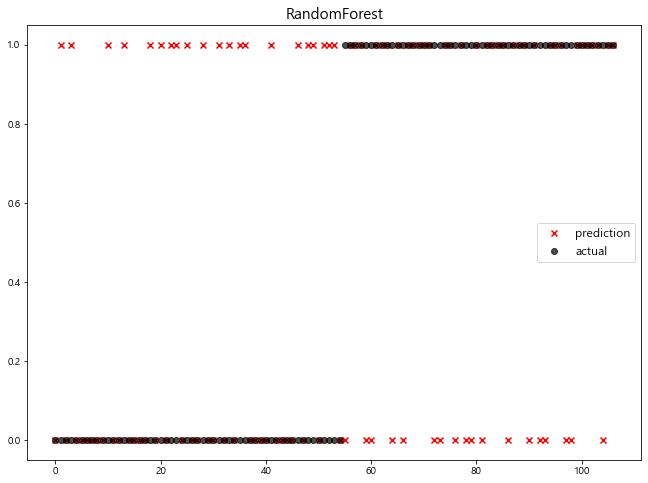

                model        f1
0  LogisticRegression  0.638655
1      KNN Classifier  0.637168
2        RandomForest  0.635514
3     RidgeClassifier  0.612613
4        DecisionTree  0.527273


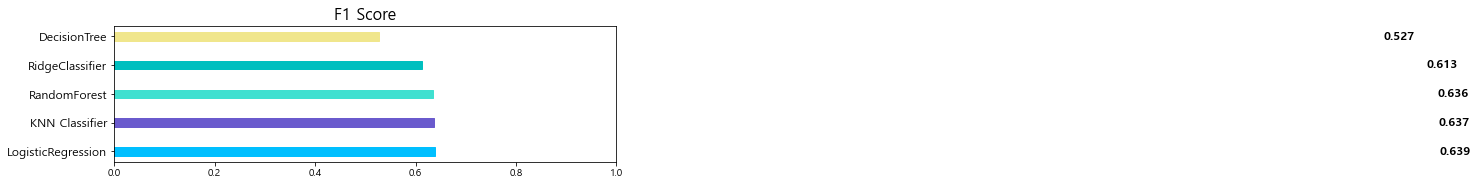

In [289]:
#RF (max_depth = 5)
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state = 0, max_depth = 5)
forest.fit(X_train, y_train)
pred = forest.predict(X_test)
print(forest.score(X_train, y_train).round(3), forest.score(X_test, y_test).round(3))
f1_eval('RandomForest', pred, y_test)

1.0 0.607


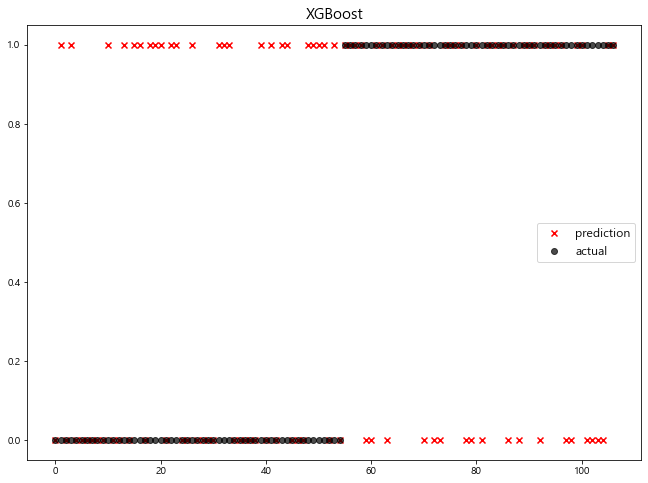

                model        f1
0  LogisticRegression  0.638655
1      KNN Classifier  0.637168
2        RandomForest  0.635514
3             XGBoost  0.618182
4     RidgeClassifier  0.612613
5        DecisionTree  0.527273


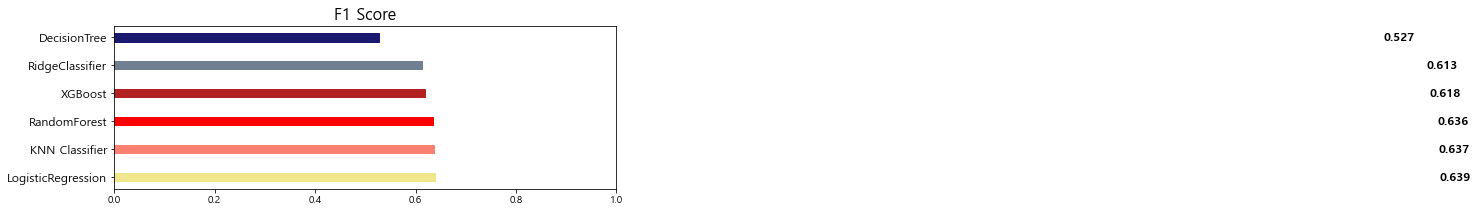

In [290]:
# XGBoost
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state = 0)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)
print(xgb.score(X_train, y_train).round(3), xgb.score(X_test, y_test).round(3))
f1_eval('XGBoost', pred, y_test)

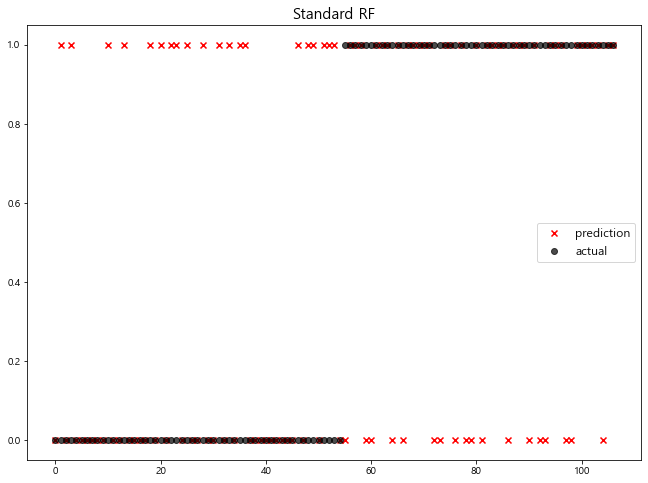

                model        f1
0         Standard RF  0.641509
1  LogisticRegression  0.638655
2      KNN Classifier  0.637168
3        RandomForest  0.635514
4             XGBoost  0.618182
5     RidgeClassifier  0.612613
6        DecisionTree  0.527273


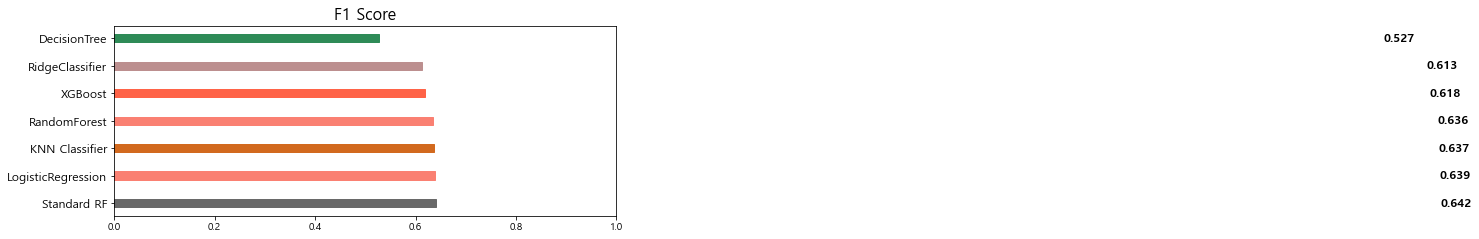

In [291]:
RF_pipeline = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(random_state = 0, max_depth = 5)
)
RF_pipeline.fit(X_train, y_train)
pred = RF_pipeline.predict(X_test)
f1_eval('Standard RF', pred, y_test)

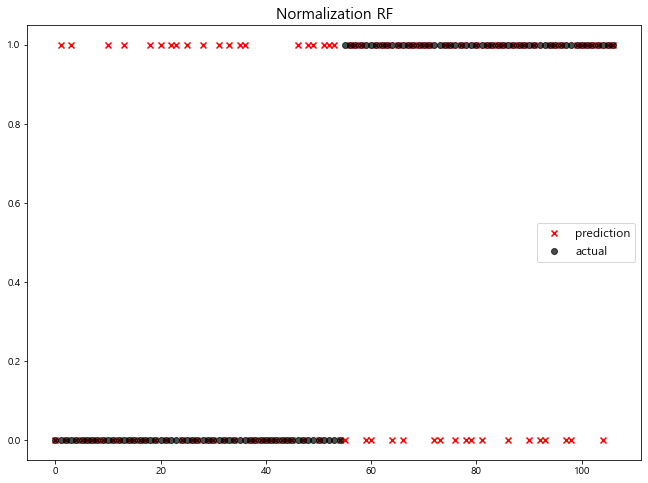

                model        f1
0         Standard RF  0.641509
1    Normalization RF  0.641509
2  LogisticRegression  0.638655
3      KNN Classifier  0.637168
4        RandomForest  0.635514
5             XGBoost  0.618182
6     RidgeClassifier  0.612613
7        DecisionTree  0.527273


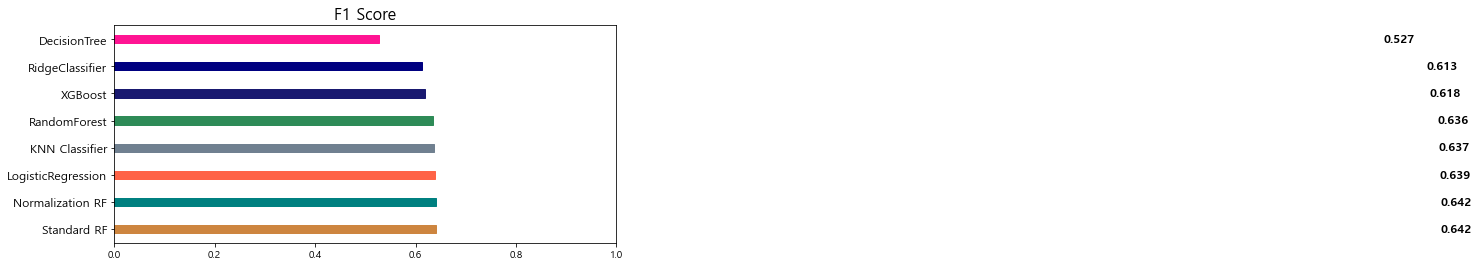

In [292]:
RF_pipeline = make_pipeline(
    MinMaxScaler(),
    RandomForestClassifier(random_state = 0, max_depth = 5)
)
RF_pipeline.fit(X_train, y_train)
pred = RF_pipeline.predict(X_test)
f1_eval('Normalization RF', pred, y_test)

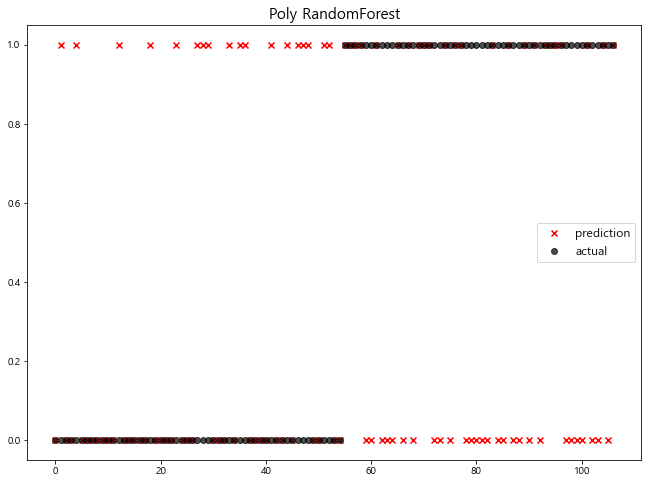

                model        f1
0         Standard RF  0.641509
1    Normalization RF  0.641509
2  LogisticRegression  0.638655
3      KNN Classifier  0.637168
4        RandomForest  0.635514
5             XGBoost  0.618182
6     RidgeClassifier  0.612613
7        DecisionTree  0.527273
8   Poly RandomForest  0.510638


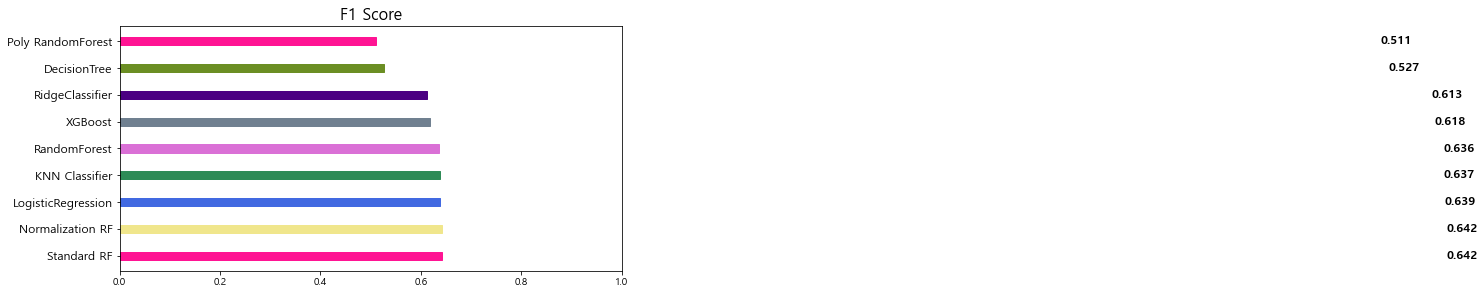

In [293]:
poly_RF_pipeline = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=2, include_bias=False),
    RandomForestClassifier(random_state = 0, max_depth = 5)
)
poly_RF_pipeline.fit(X_train, y_train)
poly_pred = poly_RF_pipeline.predict(X_test)
f1_eval('Poly RandomForest', poly_pred, y_test)

In [295]:
from sklearn.ensemble import VotingClassifier

models = [
    ('Logi', LogisticRegression()), 
    # ('ridge', RidgeClassifier()),
    # ('knn', KNeighborsClassifier()),
    # ('tree', DecisionTreeClassifier()),
    ('ranfore', RandomForestClassifier()),
    ('xgb', XGBClassifier())
]

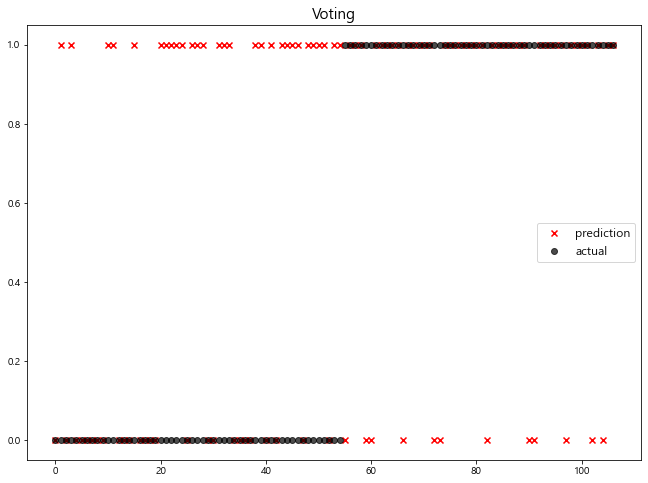

                model        f1
0              Voting  0.661157
1         Standard RF  0.641509
2    Normalization RF  0.641509
3  LogisticRegression  0.638655
4      KNN Classifier  0.637168
5        RandomForest  0.635514
6             XGBoost  0.618182
7     RidgeClassifier  0.612613
8        DecisionTree  0.527273
9   Poly RandomForest  0.510638


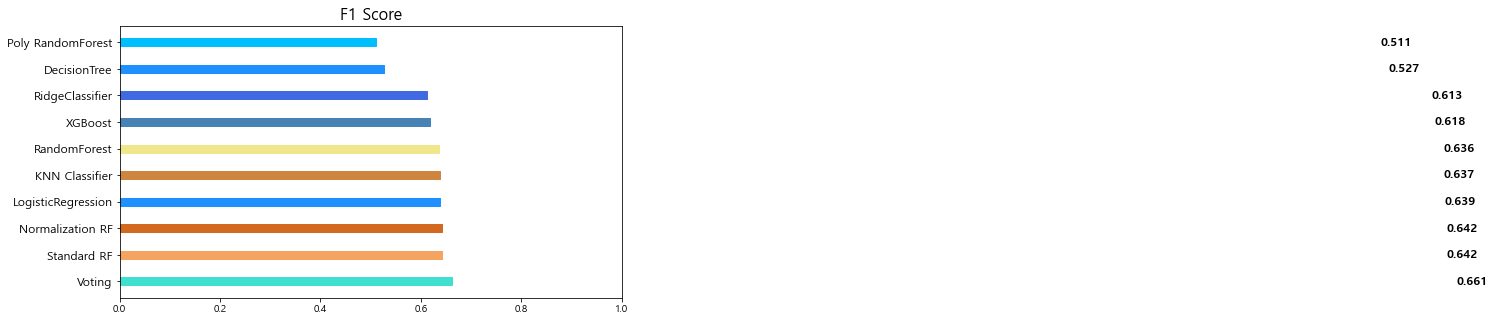

In [296]:
vc = VotingClassifier(models, voting='soft', n_jobs=-1)
vc.fit(X_train, y_train)
pred = vc.predict(X_test)
f1_eval('Voting', pred, y_test)

In [297]:
models = [
    ('Logi', LogisticRegression()), 
    # ('ridge', RidgeClassifier()),
    # ('knn', KNeighborsClassifier()),
    # ('tree', DecisionTreeClassifier()),
    ('ranfore', RF_pipeline),
    ('xgb', XGBClassifier())
]

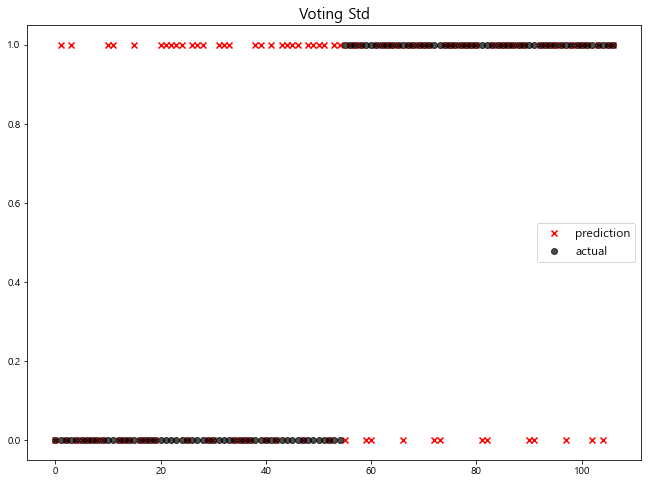

                 model        f1
0               Voting  0.661157
1           Voting Std  0.650000
2          Standard RF  0.641509
3     Normalization RF  0.641509
4   LogisticRegression  0.638655
5       KNN Classifier  0.637168
6         RandomForest  0.635514
7              XGBoost  0.618182
8      RidgeClassifier  0.612613
9         DecisionTree  0.527273
10   Poly RandomForest  0.510638


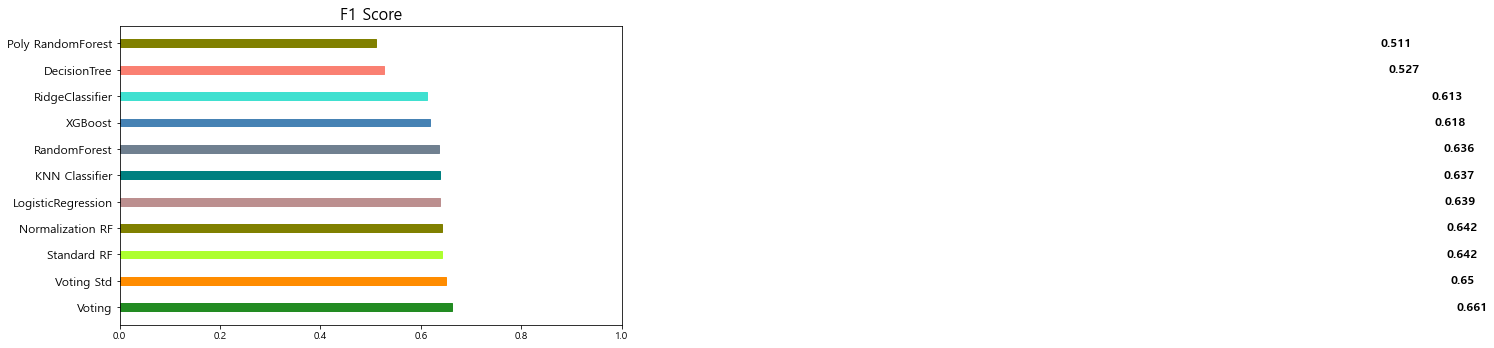

In [298]:
vc = VotingClassifier(models, voting='soft', n_jobs=-1)
vc.fit(X_train, y_train)
pred = vc.predict(X_test)
f1_eval('Voting Std', pred, y_test)

In [299]:
from sklearn.ensemble import StackingClassifier

stack_models = [
    ('randomforest', forest), 
    ('logistic', lg),
]

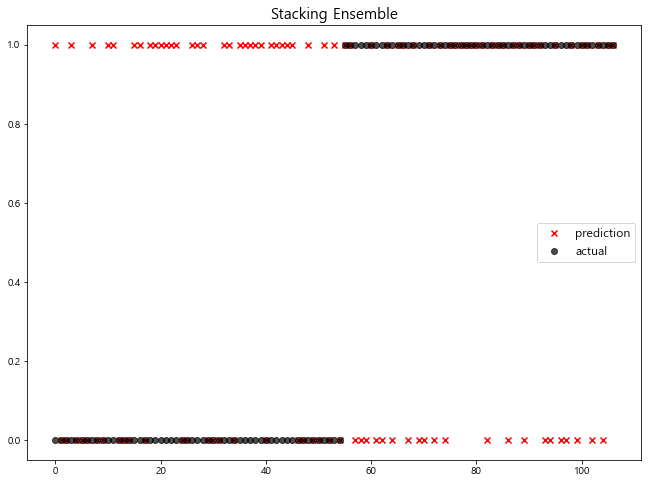

                 model        f1
0               Voting  0.661157
1           Voting Std  0.650000
2          Standard RF  0.641509
3     Normalization RF  0.641509
4   LogisticRegression  0.638655
5       KNN Classifier  0.637168
6         RandomForest  0.635514
7              XGBoost  0.618182
8      RidgeClassifier  0.612613
9    Stacking Ensemble  0.543860
10        DecisionTree  0.527273
11   Poly RandomForest  0.510638


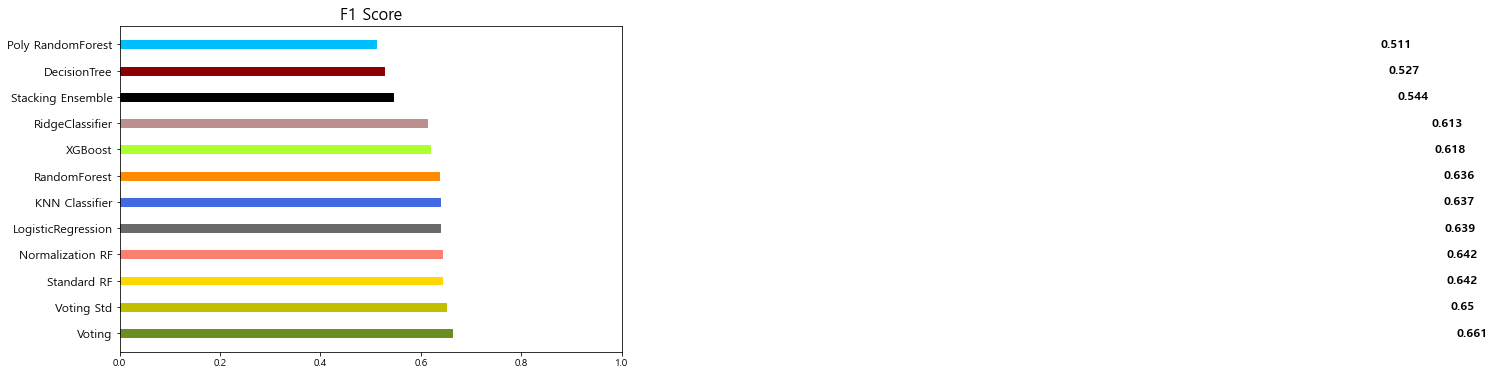

In [300]:
stack_cls = StackingClassifier(stack_models, final_estimator=xgb, n_jobs=-1)

# 샘플 데이터, 알고리즘 3개만 사용했지만 시간이 많이 걸림을 확인 가능
stack_cls.fit(X_train, y_train)
stack_pred = stack_cls.predict(X_test)
f1_eval('Stacking Ensemble', stack_pred, y_test)